In [57]:
import tensorflow as tf
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha
import itertools
import os
import cv2
import numpy as np
from random import random, randint, choices
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, AveragePooling2D, BatchNormalization
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split
from IPython.display import display
from tensorflow.keras import layers


In [14]:
#primary data set kaggle
    #use generated captcha as expriment for outside dataste testing
    #report only results
    #train the model twice, or freeze the layers and add new layers
    
#use categorical loss
#softmax
#different cnn models


In [15]:
# generated CAPTCHAs using Python ImageCaptcha Library
alphabet_all = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
#alphabet_all = list('qwertyupasdfghjkzxcvbnmo23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
num_alphabet = len(alphabet)

def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)

def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [77]:
BATCH_SIZE = (128*2)  #128
NUM_OF_LETTERS = 5
EPOCHS = 150
IMG_ROW, IMG_COLS = 40, 150
img_width = int(135/2)
img_height = int(50/2)
# Non-configs
PATH = os.getcwd() # get current path


In [17]:
# Save model and weights
def SaveModel(model, save_dir, model_name):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % save_dir)

In [67]:
#pre-processing
def load_data(path,img_type, datasetSize=-1, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []
    list = os.listdir(path) # dir is your directory path
    number_files = len(list)
    print("Total number of files in folder: ", number_files)
    
    if((datasetSize == (-1)) or (datasetSize > number_files)):
        datasetSize = number_files
        
    print("Total number of requested files: ", datasetSize)


    
    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if(counter < datasetSize):
                if '.'+ img_type in fl:
                    flr = fl.split('_')[0]
                    counter += 1
                    label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                    for i in range(NUM_OF_LETTERS):
                        label[i, alphabet.index(flr[i].lower())] = 1
        #                 label = np.zeros((50, 1))
        #                 for i in range(5):
        #                     label[i*5+int(flr[i])] = 1
                        img = cv2.imread(os.path.join(r, fl))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        img = cv2.resize(img, (int(IMG_COLS), int(IMG_ROWS)), interpolation=cv2.INTER_AREA)
                        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
                  
                    if random() < test_split:
                        y_test.append(label)
                        x_test.append(img)
                    else:
                        y_train.append(label)
                        x_train.append(img)
            else: break;

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [19]:
def EvaluateScore(model, xtrain, strain, xtest, stest):
    # Score trained model.
    scores = model.evaluate(xtrain, strain, verbose=1) #x_train, s_train
    print('Train loss:     %f' % np.mean(scores[0:5]))
    acc = 1.
    for i in range(5):
        acc *= scores[6+i]
    print('Train accuracy: %.2f' % (acc * 100.))
    scores = model.evaluate(xtest, stest, verbose=1)#x_test, s_test
    print('Test loss:     %f' % np.mean(scores[0:5]))
    acc = 1.
    for i in range(5):
        acc *= scores[6+i]
    print('Test accuracy: %.2f' % (acc * 100.))



In [20]:
def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
    val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
    loss = []
    val_loss = []
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit train' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Val' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    
    plt.plot(val_loss, label='vall')
    plt.plot(loss, label='train')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [21]:
def GetDataSet(path,image_type= 'png', size=-1):
    DATA_PATH = os.path.join(PATH, path)
    x_train, y_train, x_test, y_test = load_data(DATA_PATH, image_type, size)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #normalise the data
    x_train /= 255
    x_test /= 255
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    s_train = []
    s_test = []
    
    for i in range(NUM_OF_LETTERS):
        s_train.append(y_train[:, i, :])
        s_test.append(y_test[:, i, :])
        
    return x_train, y_train, x_test, y_test, s_train, s_test
    


    


    

In [76]:
def TrainModel(network, x_train, s_train, x_test, s_test, x_val, s_val, version ='', p=3 ,val_size=0.1, saveModel = True):
#     trainedModels = []
    (model, name) = network
        
    print("Total data set size: ", len(x_train) + len(x_test))
    print("Training size: ", len(x_train))
    print("Testing size: ", len(x_test))
    print("Validation size: ", len(x_val))
    print("Number of epochs: ", EPOCHS)        
    print("Batch size: ", BATCH_SIZE)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    model.summary()

    history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data = (x_val, s_val),
#                     validation_split= val_size,
                    callbacks = [callback])
    finished_epochs =  len(history.history['loss'])
    print("Number of finished epochs: ", finished_epochs)
    
    #modelname, number of finished epochs and batch size
    save_dir = os.path.join(PATH, 'saved_models')
    name = name + '_' + str(finished_epochs) + '_' + str(BATCH_SIZE) +'_' +version +'.h5'
    SaveModel(model, save_dir, name)
          
    plot_diagram([history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
                 [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
                 history.history['loss'],
                 history.history['val_loss'])
        
    EvaluateScore(model, x_train, s_train, x_test, s_test)
        

        
    
    return model, name, history
    
    




In [ ]:
#datasets are local!
#Big generated dataset
x_trainBig, y_trainBig, x_testBig, y_testBig, s_trainBig, s_testBig = GetDataSet('train_big', 'png', 100000)

In [ ]:
#generated dataset
x_trainGen, y_trainGen, x_testGen, y_testGen, s_trainGen, s_testGen = GetDataSet('train','png', 100000)

In [38]:
#Kaggle dataset 113062
x_trainKaggle, y_trainKaggle, x_testKaggle, y_testKaggle, s_trainKaggle, s_testKaggle = GetDataSet( 'archive', 'jpg')

x_trainKaggle, x_valKaggle, y_trainKaggle, y_valKaggle = train_test_split(
    x_trainKaggle, y_trainKaggle, test_size=0.1, random_state=42)

s_valKaggle = []
s_trainKaggle = []
  
for i in range(NUM_OF_LETTERS):
    s_valKaggle.append(y_valKaggle[:, i, :])
    s_trainKaggle.append(y_trainKaggle[:, i, :])


print(x_valKaggle.shape)

loading dataset...
Total number of files in folder:  113062
Total number of requested files:  113062
dataset size: 113062 (train=101663, test=11399)
(101663, 25, 67, 1)
(101663, 5, 62)
(11399, 25, 67, 1)
(11399, 5, 62)
(10167, 25, 67, 1)


(10178, 25, 67, 1)


In [ ]:
#Generate Captcha labels
# DATA_PATH_Gen = os.path.join(PATH, 'train')# create new folder for data
# if not os.path.exists(DATA_PATH_Gen):
#     print('Generating Dataset')
#     gen_dataset(DATA_PATH_Gen,113062 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW) #700*1000

In [24]:
save_dir = os.path.join(PATH, 'saved_models')


In [25]:
def ModelVGG19(input_shape):
    input_layer = Input(input_shape)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)  
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

      
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)

    model = Model(name ='VGG19',inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_name = 'keras_VGG19_trained_model'

    return model, model_name


In [26]:
#simplfied version 
def ModelVGG16(input_shape):
    
    input_tensor = Input(input_shape)
    x = input_tensor
    #32*2 = 64,32*4= 128,32*8=256, 32*16=512
    for i in range(4):
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)

    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
#     x = Dense(4096, activation='relu')(x)
#     x = Dropout(0.5)(x)
    
    # x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]

    model = Model(name = 'VGG16_simplfied', inputs=input_tensor, outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_name = 'keras_VGG16_trained_model'

    return model, model_name

In [27]:
#simplfied version 
def ModelVGG16complex(input_shape):
    
    input_tensor = Input(input_shape)
    x = input_tensor
    #32*2 = 64,32*4= 128,32*8=256, 32*16=512
    for i in range(4):
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)

    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]

    model = Model(name = 'VGG16Complex', inputs=input_tensor, outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_name = 'keras_VGG16Complex_trained_model'

    return model, model_name

In [28]:
#architecture
def ModelCifar10(input_shape):
    input_layer = Input(input_shape)

    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    #num_alphabet: number of classes
    #name: name of the layer
    #activation: type
    #x input from the next layer
    #NUM_OF_LETTERS: 5 in an example
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)
    model_name = 'keras_Cifar10_trained_model'

    model = Model(name = 'BaseModel', inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    return model, model_name


    

In [70]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        #label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        #label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = tf.reshape(tf.argmin(y_true, axis=-1), shape=(batch_len, 1))
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred
#     IMG_ROW, IMG_COLS 
def ModelOCR():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
   # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt, metrics=[ctc_accuracy])
    return model, "ocr_model_v1"


In [29]:
def ModelAlexnet(input_shape):
    input_layer = Input(input_shape)

    x = Conv2D(filters=96, kernel_size=(11, 11), strides= 4,  padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides = (2,2),  padding='same')(x)

    x = Conv2D(filters=256, kernel_size=(5, 5),strides= 1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)

    x = Conv2D(filters=384, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
    x = Conv2D(filters=384, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)

    x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)

    model = Model(name ='AlexNet', inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_name = 'keras_AlexNet_trained_model'
    return model, model_name


    
    
  

In [41]:

def ModelWangComplex(input_shape):
    """"
    input - conv1 - PreLu - Pool_1 - Conv2- PreLu2 - Pool_2 - Conv_3 - PReLU_3 - Pool_3 - Fc_1 - Cls_prob - loss function - Bbox_pred - loss function
    
    """
    # input layer
    input_layer = Input(input_shape)

    # Conv_1
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    
    #Conv_2
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    #Pooling P3
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Conv_4
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Conv_5
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    #Pooling P6
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Conv_7
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Conv_8
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Pooling 9
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Conv_10
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Conv_11
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    #Poolin 12
    x = MaxPooling2D(pool_size=(2, 2))(x)

    #Flattening 13
    x = Flatten()(x)

    #Dense
    x = Dense(120, activation='sigmoid')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='sigmoid')(x) for i in range(NUM_OF_LETTERS)]
    
    model = Model(inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_name = 'keras_trained_model_WangComplex.h5'
    return model, model_name

In [30]:
#LeNet-5 architecture
def ModelLeNet(input_shape):
    input_layer = Input(input_shape)

        
    x = Conv2D(filters=6, kernel_size=(5, 5), activation='tanh')(input_layer)
    x = AveragePooling2D(pool_size=(2, 2),strides=(2, 2))(x)

    x = Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh')(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(120, activation='tanh')(x)
    x = Dense(84, activation='tanh')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    
    model = Model(name= 'LeNet', inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_name = 'keras_LeNet_trained_model'
    return model, model_name




In [ ]:
# models = [ModelCifar10((25, 67, 1))]
# for (model, name) in models:
#     print(name)
#     model.summary()
    
# model, model_name = ModelCifar10((25, 67, 1))
# model_name = 'keras_Cifar10_trained_model.h5'


# model, model_name = ModelVGG19((25, 67, 1))
# model_name = 'keras_VGG19_trained_model.h5'

# model, model_name = 'keras_LeNet_trained_model.h5'
# model,model_name = ModelLeNet((25, 67, 1))

# model_name = 'keras_AlexNet_trained_model.h5'
# model,model_name = ModelAlexnet((25, 67, 1))

# model,model_name = ModelVGG16((25, 67, 1))
# model_name = 'keras_VGG16_trained_model.h5'


# model.summary()

In [71]:
model_ocr, model_ocr_name  = ModelOCR()
model_ocr.summary()

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  256
Model: "VGG16_simplfied"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 25, 67, 32)   320         input_32[0][0]                   
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 25, 67, 32)   9248        conv2d_206[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_113 (MaxPooling2D (None, 13, 34, 

2022-01-17 18:28:08.513254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


358/358 [==============================] - ETA: 0s - loss: 17.7294 - digit0_loss: 3.5468 - digit1_loss: 3.5452 - digit2_loss: 3.5461 - digit3_loss: 3.5466 - digit4_loss: 3.5446 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0329 - digit3_accuracy: 0.0335 - digit4_accuracy: 0.0338

2022-01-17 18:28:48.650856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


358/358 [==============================] - 42s 115ms/step - loss: 17.7294 - digit0_loss: 3.5468 - digit1_loss: 3.5452 - digit2_loss: 3.5461 - digit3_loss: 3.5466 - digit4_loss: 3.5446 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0329 - digit3_accuracy: 0.0335 - digit4_accuracy: 0.0338 - val_loss: 17.6082 - val_digit0_loss: 3.5211 - val_digit1_loss: 3.5212 - val_digit2_loss: 3.5209 - val_digit3_loss: 3.5209 - val_digit4_loss: 3.5241 - val_digit0_accuracy: 0.0347 - val_digit1_accuracy: 0.0330 - val_digit2_accuracy: 0.0336 - val_digit3_accuracy: 0.0349 - val_digit4_accuracy: 0.0353
Epoch 2/150
358/358 [==============================] - 40s 112ms/step - loss: 17.6139 - digit0_loss: 3.5235 - digit1_loss: 3.5218 - digit2_loss: 3.5233 - digit3_loss: 3.5231 - digit4_loss: 3.5223 - digit0_accuracy: 0.0338 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0344 - digit3_accuracy: 0.0329 - digit4_accuracy: 0.0323 - val_loss: 17.5987 - val_digit0_loss: 3.5201 - val_digit1_l

358/358 [==============================] - 40s 111ms/step - loss: 4.4176 - digit0_loss: 0.4566 - digit1_loss: 1.1099 - digit2_loss: 1.3657 - digit3_loss: 1.0863 - digit4_loss: 0.3991 - digit0_accuracy: 0.8613 - digit1_accuracy: 0.6340 - digit2_accuracy: 0.5568 - digit3_accuracy: 0.6450 - digit4_accuracy: 0.8829 - val_loss: 3.2353 - val_digit0_loss: 0.3239 - val_digit1_loss: 0.8154 - val_digit2_loss: 1.0246 - val_digit3_loss: 0.7880 - val_digit4_loss: 0.2834 - val_digit0_accuracy: 0.9042 - val_digit1_accuracy: 0.7542 - val_digit2_accuracy: 0.6848 - val_digit3_accuracy: 0.7642 - val_digit4_accuracy: 0.9201
Epoch 15/150
358/358 [==============================] - 39s 110ms/step - loss: 4.1144 - digit0_loss: 0.4251 - digit1_loss: 1.0285 - digit2_loss: 1.2834 - digit3_loss: 1.0066 - digit4_loss: 0.3708 - digit0_accuracy: 0.8685 - digit1_accuracy: 0.6609 - digit2_accuracy: 0.5875 - digit3_accuracy: 0.6728 - digit4_accuracy: 0.8901 - val_loss: 2.9952 - val_digit0_loss: 0.3149 - val_digit1_loss

358/358 [==============================] - 40s 111ms/step - loss: 2.4998 - digit0_loss: 0.2906 - digit1_loss: 0.5936 - digit2_loss: 0.7707 - digit3_loss: 0.5938 - digit4_loss: 0.2512 - digit0_accuracy: 0.9140 - digit1_accuracy: 0.8149 - digit2_accuracy: 0.7572 - digit3_accuracy: 0.8171 - digit4_accuracy: 0.9305 - val_loss: 2.1100 - val_digit0_loss: 0.2630 - val_digit1_loss: 0.4962 - val_digit2_loss: 0.6175 - val_digit3_loss: 0.4941 - val_digit4_loss: 0.2393 - val_digit0_accuracy: 0.9274 - val_digit1_accuracy: 0.8573 - val_digit2_accuracy: 0.8228 - val_digit3_accuracy: 0.8601 - val_digit4_accuracy: 0.9390
Epoch 28/150
358/358 [==============================] - 40s 111ms/step - loss: 2.4252 - digit0_loss: 0.2780 - digit1_loss: 0.5814 - digit2_loss: 0.7478 - digit3_loss: 0.5686 - digit4_loss: 0.2493 - digit0_accuracy: 0.9171 - digit1_accuracy: 0.8203 - digit2_accuracy: 0.7655 - digit3_accuracy: 0.8245 - digit4_accuracy: 0.9297 - val_loss: 2.0818 - val_digit0_loss: 0.2780 - val_digit1_loss

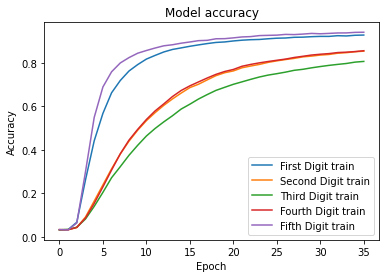

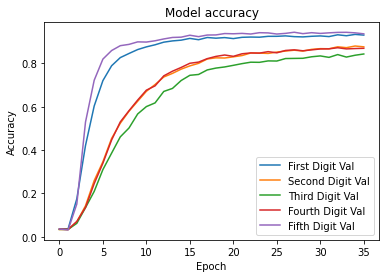

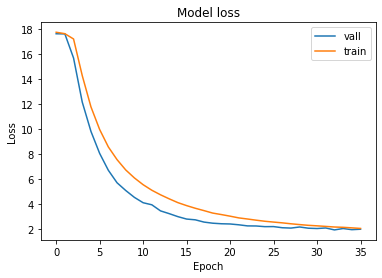

2860/2860 [==============================] - 83s 29ms/step - loss: 1.0356 - digit0_loss: 0.1142 - digit1_loss: 0.2428 - digit2_loss: 0.3154 - digit3_loss: 0.2519 - digit4_loss: 0.1114 - digit0_accuracy: 0.9631 - digit1_accuracy: 0.9233 - digit2_accuracy: 0.9050 - digit3_accuracy: 0.9191 - digit4_accuracy: 0.9661
Train loss:     0.391980
Train accuracy: 71.45
357/357 [==============================] - 10s 29ms/step - loss: 1.9643 - digit0_loss: 0.2408 - digit1_loss: 0.4506 - digit2_loss: 0.5421 - digit3_loss: 0.4643 - digit4_loss: 0.2665 - digit0_accuracy: 0.9356 - digit1_accuracy: 0.8755 - digit2_accuracy: 0.8452 - digit3_accuracy: 0.8714 - digit4_accuracy: 0.9365
Test loss:     0.732415
Test accuracy: 56.50


In [78]:
Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle, x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)) )

# Model testing
<ol>
    <li>optimizer: adam</li>
    <li>obatch size: 128 (most common one)</li>
    <li>dataset size: full</li>
    <li>greyscale vs. color (Assume for now grayscale) --> ask Albert</li>
    <li>test size: 10%</li>
    <li>validation set: 10%</li>
    <li>number of epochs: 150 (with early stopping)</li>
    <li>early stopping max patience: 5</li>
</ol>



---Start new train trial---
Patience:  1
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "BaseModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 25, 67, 32)   832         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 12, 33, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (C

2022-01-16 23:59:21.951031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-16 23:59:21.951186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-16 23:59:22.271593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 16.0668 - digit0_loss: 3.0350 - digit1_loss: 3.2895 - digit2_loss: 3.3237 - digit3_loss: 3.3271 - digit4_loss: 3.0915 - digit0_accuracy: 0.1453 - digit1_accuracy: 0.0928 - digit2_accuracy: 0.0856 - digit3_accuracy: 0.0864 - digit4_accuracy: 0.1364

2022-01-16 23:59:44.874082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 24s 33ms/step - loss: 16.0668 - digit0_loss: 3.0350 - digit1_loss: 3.2895 - digit2_loss: 3.3237 - digit3_loss: 3.3271 - digit4_loss: 3.0915 - digit0_accuracy: 0.1453 - digit1_accuracy: 0.0928 - digit2_accuracy: 0.0856 - digit3_accuracy: 0.0864 - digit4_accuracy: 0.1364 - val_loss: 11.8448 - val_digit0_loss: 1.8890 - val_digit1_loss: 2.5814 - val_digit2_loss: 2.7003 - val_digit3_loss: 2.6898 - val_digit4_loss: 1.9843 - val_digit0_accuracy: 0.4316 - val_digit1_accuracy: 0.2716 - val_digit2_accuracy: 0.2361 - val_digit3_accuracy: 0.2323 - val_digit4_accuracy: 0.4155
Epoch 2/150
715/715 [==============================] - 24s 33ms/step - loss: 10.7988 - digit0_loss: 1.6445 - digit1_loss: 2.3921 - digit2_loss: 2.5205 - digit3_loss: 2.5106 - digit4_loss: 1.7311 - digit0_accuracy: 0.4864 - digit1_accuracy: 0.3117 - digit2_accuracy: 0.2846 - digit3_accuracy: 0.2848 - digit4_accuracy: 0.4674 - val_loss: 8.3347 - val_digit0_loss: 1.1728 - val_digit1_loss

715/715 [==============================] - 23s 33ms/step - loss: 4.6212 - digit0_loss: 0.6039 - digit1_loss: 1.0558 - digit2_loss: 1.2168 - digit3_loss: 1.1052 - digit4_loss: 0.6393 - digit0_accuracy: 0.8059 - digit1_accuracy: 0.6827 - digit2_accuracy: 0.6420 - digit3_accuracy: 0.6665 - digit4_accuracy: 0.7933 - val_loss: 3.5839 - val_digit0_loss: 0.4307 - val_digit1_loss: 0.8443 - val_digit2_loss: 0.9932 - val_digit3_loss: 0.8600 - val_digit4_loss: 0.4557 - val_digit0_accuracy: 0.8633 - val_digit1_accuracy: 0.7538 - val_digit2_accuracy: 0.7146 - val_digit3_accuracy: 0.7506 - val_digit4_accuracy: 0.8561
Epoch 15/150
715/715 [==============================] - 24s 33ms/step - loss: 4.4982 - digit0_loss: 0.5878 - digit1_loss: 1.0315 - digit2_loss: 1.1851 - digit3_loss: 1.0751 - digit4_loss: 0.6188 - digit0_accuracy: 0.8095 - digit1_accuracy: 0.6913 - digit2_accuracy: 0.6517 - digit3_accuracy: 0.6754 - digit4_accuracy: 0.8015 - val_loss: 3.5340 - val_digit0_loss: 0.4164 - val_digit1_loss: 

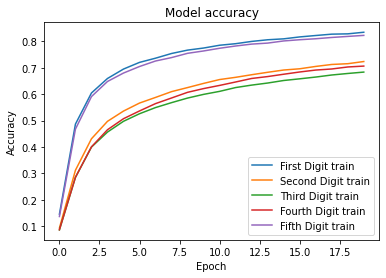

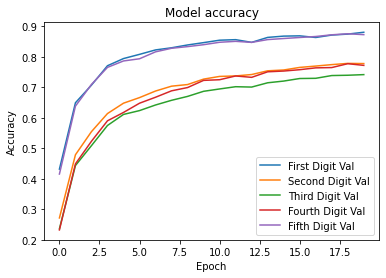

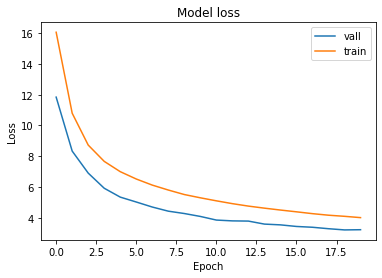

2860/2860 [==============================] - 49s 17ms/step - loss: 2.2246 - digit0_loss: 0.2323 - digit1_loss: 0.5350 - digit2_loss: 0.6554 - digit3_loss: 0.5477 - digit4_loss: 0.2542 - digit0_accuracy: 0.9321 - digit1_accuracy: 0.8518 - digit2_accuracy: 0.8201 - digit3_accuracy: 0.8485 - digit4_accuracy: 0.9259
Train loss:     0.839000
Train accuracy: 51.15
357/357 [==============================] - 6s 17ms/step - loss: 3.2161 - digit0_loss: 0.3690 - digit1_loss: 0.7549 - digit2_loss: 0.9064 - digit3_loss: 0.7874 - digit4_loss: 0.3984 - digit0_accuracy: 0.8803 - digit1_accuracy: 0.7802 - digit2_accuracy: 0.7409 - digit3_accuracy: 0.7688 - digit4_accuracy: 0.8746
Test loss:     1.206760
Test accuracy: 34.22

---Start new train trial---
Patience:  2
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "BaseModel"
______________________________________________________________________________________

2022-01-17 00:08:08.651112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 16.1271 - digit0_loss: 3.0430 - digit1_loss: 3.3008 - digit2_loss: 3.3351 - digit3_loss: 3.3358 - digit4_loss: 3.1125 - digit0_accuracy: 0.1439 - digit1_accuracy: 0.0881 - digit2_accuracy: 0.0836 - digit3_accuracy: 0.0847 - digit4_accuracy: 0.1307

2022-01-17 00:08:31.553945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 24s 34ms/step - loss: 16.1271 - digit0_loss: 3.0430 - digit1_loss: 3.3008 - digit2_loss: 3.3351 - digit3_loss: 3.3358 - digit4_loss: 3.1125 - digit0_accuracy: 0.1439 - digit1_accuracy: 0.0881 - digit2_accuracy: 0.0836 - digit3_accuracy: 0.0847 - digit4_accuracy: 0.1307 - val_loss: 12.1793 - val_digit0_loss: 1.9297 - val_digit1_loss: 2.6445 - val_digit2_loss: 2.7655 - val_digit3_loss: 2.7718 - val_digit4_loss: 2.0678 - val_digit0_accuracy: 0.4300 - val_digit1_accuracy: 0.2626 - val_digit2_accuracy: 0.2296 - val_digit3_accuracy: 0.2234 - val_digit4_accuracy: 0.3920
Epoch 2/150
715/715 [==============================] - 24s 34ms/step - loss: 11.0916 - digit0_loss: 1.7017 - digit1_loss: 2.4377 - digit2_loss: 2.5627 - digit3_loss: 2.5857 - digit4_loss: 1.8038 - digit0_accuracy: 0.4683 - digit1_accuracy: 0.3014 - digit2_accuracy: 0.2748 - digit3_accuracy: 0.2650 - digit4_accuracy: 0.4500 - val_loss: 8.5726 - val_digit0_loss: 1.2048 - val_digit1_loss

715/715 [==============================] - 24s 33ms/step - loss: 4.9721 - digit0_loss: 0.6595 - digit1_loss: 1.1305 - digit2_loss: 1.2935 - digit3_loss: 1.1991 - digit4_loss: 0.6895 - digit0_accuracy: 0.7877 - digit1_accuracy: 0.6631 - digit2_accuracy: 0.6234 - digit3_accuracy: 0.6437 - digit4_accuracy: 0.7786 - val_loss: 3.8150 - val_digit0_loss: 0.4745 - val_digit1_loss: 0.8898 - val_digit2_loss: 1.0522 - val_digit3_loss: 0.9212 - val_digit4_loss: 0.4773 - val_digit0_accuracy: 0.8507 - val_digit1_accuracy: 0.7471 - val_digit2_accuracy: 0.7054 - val_digit3_accuracy: 0.7286 - val_digit4_accuracy: 0.8519
Epoch 15/150
715/715 [==============================] - 24s 33ms/step - loss: 4.8625 - digit0_loss: 0.6435 - digit1_loss: 1.1059 - digit2_loss: 1.2649 - digit3_loss: 1.1706 - digit4_loss: 0.6774 - digit0_accuracy: 0.7923 - digit1_accuracy: 0.6690 - digit2_accuracy: 0.6301 - digit3_accuracy: 0.6492 - digit4_accuracy: 0.7836 - val_loss: 3.7119 - val_digit0_loss: 0.4596 - val_digit1_loss: 

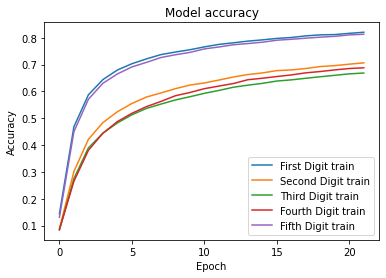

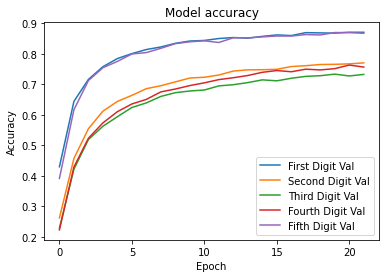

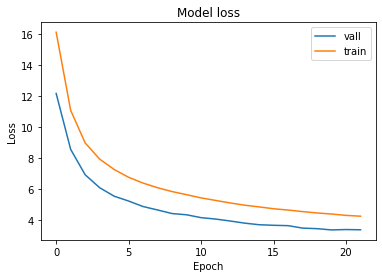

2860/2860 [==============================] - 50s 18ms/step - loss: 2.4782 - digit0_loss: 0.2754 - digit1_loss: 0.5885 - digit2_loss: 0.7195 - digit3_loss: 0.6140 - digit4_loss: 0.2808 - digit0_accuracy: 0.9181 - digit1_accuracy: 0.8359 - digit2_accuracy: 0.7988 - digit3_accuracy: 0.8295 - digit4_accuracy: 0.9173
Train loss:     0.935101
Train accuracy: 46.65
357/357 [==============================] - 6s 18ms/step - loss: 3.3925 - digit0_loss: 0.4119 - digit1_loss: 0.7929 - digit2_loss: 0.9520 - digit3_loss: 0.8214 - digit4_loss: 0.4143 - digit0_accuracy: 0.8683 - digit1_accuracy: 0.7679 - digit2_accuracy: 0.7317 - digit3_accuracy: 0.7574 - digit4_accuracy: 0.8704
Test loss:     1.274148
Test accuracy: 32.17

---Start new train trial---
Patience:  3
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "BaseModel"
______________________________________________________________________________________

2022-01-17 00:17:57.505048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 16.4051 - digit0_loss: 3.1313 - digit1_loss: 3.3427 - digit2_loss: 3.3719 - digit3_loss: 3.3718 - digit4_loss: 3.1875 - digit0_accuracy: 0.1218 - digit1_accuracy: 0.0807 - digit2_accuracy: 0.0770 - digit3_accuracy: 0.0753 - digit4_accuracy: 0.1161

2022-01-17 00:18:20.550761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 25s 34ms/step - loss: 16.4051 - digit0_loss: 3.1313 - digit1_loss: 3.3427 - digit2_loss: 3.3719 - digit3_loss: 3.3718 - digit4_loss: 3.1875 - digit0_accuracy: 0.1218 - digit1_accuracy: 0.0807 - digit2_accuracy: 0.0770 - digit3_accuracy: 0.0753 - digit4_accuracy: 0.1161 - val_loss: 12.5645 - val_digit0_loss: 2.0516 - val_digit1_loss: 2.7394 - val_digit2_loss: 2.8218 - val_digit3_loss: 2.8134 - val_digit4_loss: 2.1383 - val_digit0_accuracy: 0.3878 - val_digit1_accuracy: 0.2173 - val_digit2_accuracy: 0.2127 - val_digit3_accuracy: 0.2069 - val_digit4_accuracy: 0.3816
Epoch 2/150
715/715 [==============================] - 26s 36ms/step - loss: 11.1846 - digit0_loss: 1.7224 - digit1_loss: 2.4669 - digit2_loss: 2.5912 - digit3_loss: 2.5926 - digit4_loss: 1.8117 - digit0_accuracy: 0.4660 - digit1_accuracy: 0.2931 - digit2_accuracy: 0.2680 - digit3_accuracy: 0.2640 - digit4_accuracy: 0.4494 - val_loss: 8.4246 - val_digit0_loss: 1.1558 - val_digit1_loss

715/715 [==============================] - 25s 35ms/step - loss: 4.7452 - digit0_loss: 0.6041 - digit1_loss: 1.0933 - digit2_loss: 1.2447 - digit3_loss: 1.1436 - digit4_loss: 0.6595 - digit0_accuracy: 0.8041 - digit1_accuracy: 0.6717 - digit2_accuracy: 0.6339 - digit3_accuracy: 0.6551 - digit4_accuracy: 0.7874 - val_loss: 3.7348 - val_digit0_loss: 0.4595 - val_digit1_loss: 0.8643 - val_digit2_loss: 1.0340 - val_digit3_loss: 0.9048 - val_digit4_loss: 0.4721 - val_digit0_accuracy: 0.8535 - val_digit1_accuracy: 0.7525 - val_digit2_accuracy: 0.7032 - val_digit3_accuracy: 0.7395 - val_digit4_accuracy: 0.8487
Epoch 15/150
715/715 [==============================] - 26s 36ms/step - loss: 4.6330 - digit0_loss: 0.6016 - digit1_loss: 1.0649 - digit2_loss: 1.2199 - digit3_loss: 1.1035 - digit4_loss: 0.6431 - digit0_accuracy: 0.8061 - digit1_accuracy: 0.6804 - digit2_accuracy: 0.6410 - digit3_accuracy: 0.6661 - digit4_accuracy: 0.7927 - val_loss: 3.6152 - val_digit0_loss: 0.4495 - val_digit1_loss: 

715/715 [==============================] - 25s 35ms/step - loss: 3.7358 - digit0_loss: 0.4706 - digit1_loss: 0.8679 - digit2_loss: 0.9937 - digit3_loss: 0.8946 - digit4_loss: 0.5090 - digit0_accuracy: 0.8466 - digit1_accuracy: 0.7357 - digit2_accuracy: 0.7017 - digit3_accuracy: 0.7248 - digit4_accuracy: 0.8362 - val_loss: 3.1202 - val_digit0_loss: 0.3876 - val_digit1_loss: 0.7308 - val_digit2_loss: 0.8628 - val_digit3_loss: 0.7383 - val_digit4_loss: 0.4007 - val_digit0_accuracy: 0.8774 - val_digit1_accuracy: 0.7831 - val_digit2_accuracy: 0.7557 - val_digit3_accuracy: 0.7822 - val_digit4_accuracy: 0.8746
Epoch 28/150
715/715 [==============================] - 25s 35ms/step - loss: 3.6971 - digit0_loss: 0.4722 - digit1_loss: 0.8574 - digit2_loss: 0.9772 - digit3_loss: 0.8844 - digit4_loss: 0.5059 - digit0_accuracy: 0.8472 - digit1_accuracy: 0.7374 - digit2_accuracy: 0.7057 - digit3_accuracy: 0.7275 - digit4_accuracy: 0.8367 - val_loss: 3.0437 - val_digit0_loss: 0.3825 - val_digit1_loss: 

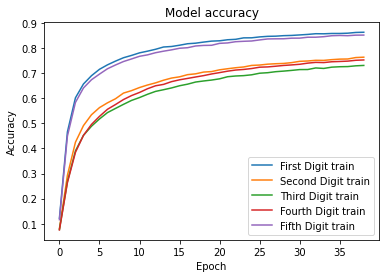

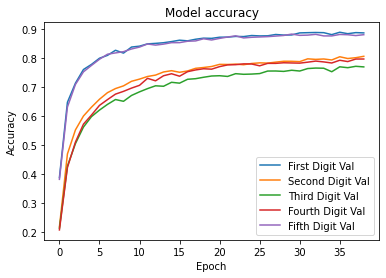

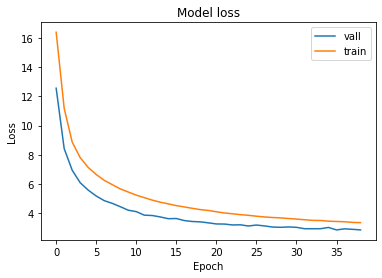

2860/2860 [==============================] - 54s 19ms/step - loss: 1.6176 - digit0_loss: 0.1705 - digit1_loss: 0.3918 - digit2_loss: 0.4733 - digit3_loss: 0.3994 - digit4_loss: 0.1826 - digit0_accuracy: 0.9475 - digit1_accuracy: 0.8899 - digit2_accuracy: 0.8699 - digit3_accuracy: 0.8865 - digit4_accuracy: 0.9464
Train loss:     0.610515
Train accuracy: 61.54
357/357 [==============================] - 7s 20ms/step - loss: 2.8635 - digit0_loss: 0.3432 - digit1_loss: 0.6737 - digit2_loss: 0.7967 - digit3_loss: 0.6916 - digit4_loss: 0.3583 - digit0_accuracy: 0.8901 - digit1_accuracy: 0.8025 - digit2_accuracy: 0.7701 - digit3_accuracy: 0.7916 - digit4_accuracy: 0.8817
Test loss:     1.073754
Test accuracy: 38.39

---Start new train trial---
Patience:  4
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "BaseModel"
______________________________________________________________________________________

2022-01-17 00:35:20.129648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 16.3799 - digit0_loss: 3.1201 - digit1_loss: 3.3356 - digit2_loss: 3.3615 - digit3_loss: 3.3659 - digit4_loss: 3.1968 - digit0_accuracy: 0.1215 - digit1_accuracy: 0.0813 - digit2_accuracy: 0.0763 - digit3_accuracy: 0.0750 - digit4_accuracy: 0.1074

2022-01-17 00:35:44.702164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 27s 36ms/step - loss: 16.3799 - digit0_loss: 3.1201 - digit1_loss: 3.3356 - digit2_loss: 3.3615 - digit3_loss: 3.3659 - digit4_loss: 3.1968 - digit0_accuracy: 0.1215 - digit1_accuracy: 0.0813 - digit2_accuracy: 0.0763 - digit3_accuracy: 0.0750 - digit4_accuracy: 0.1074 - val_loss: 12.8550 - val_digit0_loss: 2.0864 - val_digit1_loss: 2.7758 - val_digit2_loss: 2.8351 - val_digit3_loss: 2.8589 - val_digit4_loss: 2.2988 - val_digit0_accuracy: 0.3706 - val_digit1_accuracy: 0.2177 - val_digit2_accuracy: 0.1983 - val_digit3_accuracy: 0.1932 - val_digit4_accuracy: 0.3301
Epoch 2/150
715/715 [==============================] - 24s 34ms/step - loss: 11.5149 - digit0_loss: 1.7889 - digit1_loss: 2.5209 - digit2_loss: 2.6380 - digit3_loss: 2.6497 - digit4_loss: 1.9174 - digit0_accuracy: 0.4389 - digit1_accuracy: 0.2743 - digit2_accuracy: 0.2487 - digit3_accuracy: 0.2444 - digit4_accuracy: 0.4158 - val_loss: 8.7829 - val_digit0_loss: 1.2489 - val_digit1_loss

715/715 [==============================] - 25s 35ms/step - loss: 5.0401 - digit0_loss: 0.6533 - digit1_loss: 1.1440 - digit2_loss: 1.3199 - digit3_loss: 1.2163 - digit4_loss: 0.7066 - digit0_accuracy: 0.7907 - digit1_accuracy: 0.6585 - digit2_accuracy: 0.6164 - digit3_accuracy: 0.6361 - digit4_accuracy: 0.7740 - val_loss: 3.8058 - val_digit0_loss: 0.4617 - val_digit1_loss: 0.8896 - val_digit2_loss: 1.0455 - val_digit3_loss: 0.9263 - val_digit4_loss: 0.4827 - val_digit0_accuracy: 0.8520 - val_digit1_accuracy: 0.7405 - val_digit2_accuracy: 0.7001 - val_digit3_accuracy: 0.7323 - val_digit4_accuracy: 0.8475
Epoch 15/150
715/715 [==============================] - 25s 35ms/step - loss: 4.8975 - digit0_loss: 0.6324 - digit1_loss: 1.1194 - digit2_loss: 1.2762 - digit3_loss: 1.1878 - digit4_loss: 0.6817 - digit0_accuracy: 0.7951 - digit1_accuracy: 0.6657 - digit2_accuracy: 0.6260 - digit3_accuracy: 0.6451 - digit4_accuracy: 0.7810 - val_loss: 3.7245 - val_digit0_loss: 0.4568 - val_digit1_loss: 

715/715 [==============================] - 25s 35ms/step - loss: 3.9312 - digit0_loss: 0.4997 - digit1_loss: 0.9006 - digit2_loss: 1.0448 - digit3_loss: 0.9508 - digit4_loss: 0.5353 - digit0_accuracy: 0.8376 - digit1_accuracy: 0.7254 - digit2_accuracy: 0.6895 - digit3_accuracy: 0.7097 - digit4_accuracy: 0.8278 - val_loss: 3.1236 - val_digit0_loss: 0.3818 - val_digit1_loss: 0.7260 - val_digit2_loss: 0.8634 - val_digit3_loss: 0.7476 - val_digit4_loss: 0.4048 - val_digit0_accuracy: 0.8746 - val_digit1_accuracy: 0.7821 - val_digit2_accuracy: 0.7469 - val_digit3_accuracy: 0.7744 - val_digit4_accuracy: 0.8677
Epoch 28/150
715/715 [==============================] - 25s 35ms/step - loss: 3.8916 - digit0_loss: 0.4930 - digit1_loss: 0.8909 - digit2_loss: 1.0338 - digit3_loss: 0.9471 - digit4_loss: 0.5268 - digit0_accuracy: 0.8390 - digit1_accuracy: 0.7296 - digit2_accuracy: 0.6910 - digit3_accuracy: 0.7129 - digit4_accuracy: 0.8305 - val_loss: 3.0834 - val_digit0_loss: 0.3816 - val_digit1_loss: 

715/715 [==============================] - 25s 35ms/step - loss: 3.4579 - digit0_loss: 0.4446 - digit1_loss: 0.7904 - digit2_loss: 0.9237 - digit3_loss: 0.8376 - digit4_loss: 0.4616 - digit0_accuracy: 0.8562 - digit1_accuracy: 0.7569 - digit2_accuracy: 0.7222 - digit3_accuracy: 0.7420 - digit4_accuracy: 0.8495 - val_loss: 2.8662 - val_digit0_loss: 0.3562 - val_digit1_loss: 0.6634 - val_digit2_loss: 0.7951 - val_digit3_loss: 0.6848 - val_digit4_loss: 0.3667 - val_digit0_accuracy: 0.8890 - val_digit1_accuracy: 0.7972 - val_digit2_accuracy: 0.7701 - val_digit3_accuracy: 0.7979 - val_digit4_accuracy: 0.8832
Epoch 41/150
715/715 [==============================] - 25s 36ms/step - loss: 3.4490 - digit0_loss: 0.4340 - digit1_loss: 0.7905 - digit2_loss: 0.9245 - digit3_loss: 0.8325 - digit4_loss: 0.4675 - digit0_accuracy: 0.8593 - digit1_accuracy: 0.7573 - digit2_accuracy: 0.7207 - digit3_accuracy: 0.7433 - digit4_accuracy: 0.8512 - val_loss: 2.8648 - val_digit0_loss: 0.3491 - val_digit1_loss: 

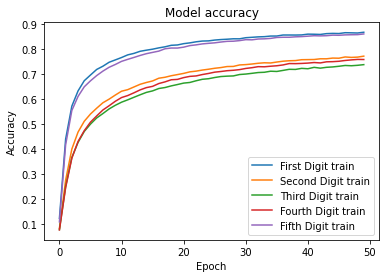

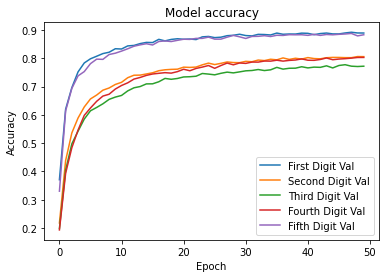

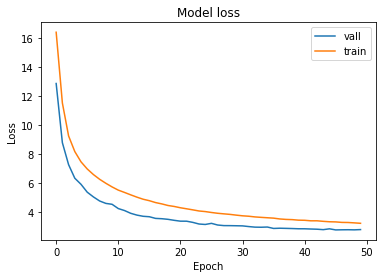

2860/2860 [==============================] - 55s 19ms/step - loss: 1.5942 - digit0_loss: 0.1732 - digit1_loss: 0.3773 - digit2_loss: 0.4697 - digit3_loss: 0.3969 - digit4_loss: 0.1771 - digit0_accuracy: 0.9455 - digit1_accuracy: 0.8929 - digit2_accuracy: 0.8680 - digit3_accuracy: 0.8884 - digit4_accuracy: 0.9461
Train loss:     0.602242
Train accuracy: 61.59
357/357 [==============================] - 7s 19ms/step - loss: 2.7933 - digit0_loss: 0.3357 - digit1_loss: 0.6630 - digit2_loss: 0.7749 - digit3_loss: 0.6779 - digit4_loss: 0.3418 - digit0_accuracy: 0.8956 - digit1_accuracy: 0.8055 - digit2_accuracy: 0.7750 - digit3_accuracy: 0.7978 - digit4_accuracy: 0.8902
Test loss:     1.048960
Test accuracy: 39.70

---Start new train trial---
Patience:  5
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "BaseModel"
______________________________________________________________________________________

2022-01-17 00:57:15.361768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 16.2766 - digit0_loss: 3.0789 - digit1_loss: 3.3231 - digit2_loss: 3.3519 - digit3_loss: 3.3564 - digit4_loss: 3.1662 - digit0_accuracy: 0.1338 - digit1_accuracy: 0.0838 - digit2_accuracy: 0.0804 - digit3_accuracy: 0.0781 - digit4_accuracy: 0.1178

2022-01-17 00:57:39.318730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 26s 35ms/step - loss: 16.2766 - digit0_loss: 3.0789 - digit1_loss: 3.3231 - digit2_loss: 3.3519 - digit3_loss: 3.3564 - digit4_loss: 3.1662 - digit0_accuracy: 0.1338 - digit1_accuracy: 0.0838 - digit2_accuracy: 0.0804 - digit3_accuracy: 0.0781 - digit4_accuracy: 0.1178 - val_loss: 12.4582 - val_digit0_loss: 1.9933 - val_digit1_loss: 2.7123 - val_digit2_loss: 2.8153 - val_digit3_loss: 2.8019 - val_digit4_loss: 2.1355 - val_digit0_accuracy: 0.4042 - val_digit1_accuracy: 0.2387 - val_digit2_accuracy: 0.2103 - val_digit3_accuracy: 0.2199 - val_digit4_accuracy: 0.3818
Epoch 2/150
715/715 [==============================] - 25s 35ms/step - loss: 11.1859 - digit0_loss: 1.7303 - digit1_loss: 2.4581 - digit2_loss: 2.5897 - digit3_loss: 2.5879 - digit4_loss: 1.8198 - digit0_accuracy: 0.4603 - digit1_accuracy: 0.2925 - digit2_accuracy: 0.2648 - digit3_accuracy: 0.2621 - digit4_accuracy: 0.4455 - val_loss: 8.6399 - val_digit0_loss: 1.2365 - val_digit1_loss

715/715 [==============================] - 25s 35ms/step - loss: 4.8476 - digit0_loss: 0.6310 - digit1_loss: 1.1037 - digit2_loss: 1.2741 - digit3_loss: 1.1755 - digit4_loss: 0.6633 - digit0_accuracy: 0.7968 - digit1_accuracy: 0.6679 - digit2_accuracy: 0.6265 - digit3_accuracy: 0.6473 - digit4_accuracy: 0.7858 - val_loss: 3.7842 - val_digit0_loss: 0.4459 - val_digit1_loss: 0.8875 - val_digit2_loss: 1.0582 - val_digit3_loss: 0.9194 - val_digit4_loss: 0.4732 - val_digit0_accuracy: 0.8627 - val_digit1_accuracy: 0.7392 - val_digit2_accuracy: 0.6987 - val_digit3_accuracy: 0.7299 - val_digit4_accuracy: 0.8478
Epoch 15/150
715/715 [==============================] - 25s 35ms/step - loss: 4.7484 - digit0_loss: 0.6123 - digit1_loss: 1.0867 - digit2_loss: 1.2525 - digit3_loss: 1.1467 - digit4_loss: 0.6502 - digit0_accuracy: 0.8023 - digit1_accuracy: 0.6741 - digit2_accuracy: 0.6329 - digit3_accuracy: 0.6554 - digit4_accuracy: 0.7917 - val_loss: 3.7605 - val_digit0_loss: 0.4510 - val_digit1_loss: 

715/715 [==============================] - 25s 35ms/step - loss: 3.7701 - digit0_loss: 0.4808 - digit1_loss: 0.8607 - digit2_loss: 1.0076 - digit3_loss: 0.9102 - digit4_loss: 0.5108 - digit0_accuracy: 0.8450 - digit1_accuracy: 0.7356 - digit2_accuracy: 0.6964 - digit3_accuracy: 0.7207 - digit4_accuracy: 0.8349 - val_loss: 3.0718 - val_digit0_loss: 0.3654 - val_digit1_loss: 0.7108 - val_digit2_loss: 0.8663 - val_digit3_loss: 0.7397 - val_digit4_loss: 0.3895 - val_digit0_accuracy: 0.8849 - val_digit1_accuracy: 0.7889 - val_digit2_accuracy: 0.7446 - val_digit3_accuracy: 0.7777 - val_digit4_accuracy: 0.8760
Epoch 28/150
715/715 [==============================] - 26s 36ms/step - loss: 3.7155 - digit0_loss: 0.4734 - digit1_loss: 0.8476 - digit2_loss: 0.9937 - digit3_loss: 0.8982 - digit4_loss: 0.5027 - digit0_accuracy: 0.8457 - digit1_accuracy: 0.7402 - digit2_accuracy: 0.7032 - digit3_accuracy: 0.7262 - digit4_accuracy: 0.8386 - val_loss: 3.0744 - val_digit0_loss: 0.3673 - val_digit1_loss: 

715/715 [==============================] - 25s 35ms/step - loss: 3.2818 - digit0_loss: 0.4178 - digit1_loss: 0.7569 - digit2_loss: 0.8756 - digit3_loss: 0.7871 - digit4_loss: 0.4443 - digit0_accuracy: 0.8624 - digit1_accuracy: 0.7673 - digit2_accuracy: 0.7352 - digit3_accuracy: 0.7586 - digit4_accuracy: 0.8564 - val_loss: 2.8409 - val_digit0_loss: 0.3462 - val_digit1_loss: 0.6532 - val_digit2_loss: 0.7857 - val_digit3_loss: 0.6892 - val_digit4_loss: 0.3665 - val_digit0_accuracy: 0.8913 - val_digit1_accuracy: 0.8085 - val_digit2_accuracy: 0.7709 - val_digit3_accuracy: 0.7939 - val_digit4_accuracy: 0.8816
Epoch 41/150
715/715 [==============================] - 25s 35ms/step - loss: 3.2635 - digit0_loss: 0.4168 - digit1_loss: 0.7491 - digit2_loss: 0.8705 - digit3_loss: 0.7848 - digit4_loss: 0.4423 - digit0_accuracy: 0.8645 - digit1_accuracy: 0.7698 - digit2_accuracy: 0.7363 - digit3_accuracy: 0.7580 - digit4_accuracy: 0.8570 - val_loss: 2.7988 - val_digit0_loss: 0.3349 - val_digit1_loss: 

715/715 [==============================] - 25s 34ms/step - loss: 3.0253 - digit0_loss: 0.3829 - digit1_loss: 0.6937 - digit2_loss: 0.8130 - digit3_loss: 0.7311 - digit4_loss: 0.4045 - digit0_accuracy: 0.8755 - digit1_accuracy: 0.7827 - digit2_accuracy: 0.7529 - digit3_accuracy: 0.7732 - digit4_accuracy: 0.8685 - val_loss: 2.7316 - val_digit0_loss: 0.3308 - val_digit1_loss: 0.6273 - val_digit2_loss: 0.7630 - val_digit3_loss: 0.6574 - val_digit4_loss: 0.3532 - val_digit0_accuracy: 0.8989 - val_digit1_accuracy: 0.8061 - val_digit2_accuracy: 0.7796 - val_digit3_accuracy: 0.8057 - val_digit4_accuracy: 0.8870
Epoch 54/150
715/715 [==============================] - 25s 35ms/step - loss: 3.0284 - digit0_loss: 0.3836 - digit1_loss: 0.6924 - digit2_loss: 0.8055 - digit3_loss: 0.7320 - digit4_loss: 0.4150 - digit0_accuracy: 0.8738 - digit1_accuracy: 0.7834 - digit2_accuracy: 0.7548 - digit3_accuracy: 0.7732 - digit4_accuracy: 0.8656 - val_loss: 2.7363 - val_digit0_loss: 0.3316 - val_digit1_loss: 

715/715 [==============================] - 25s 35ms/step - loss: 2.8781 - digit0_loss: 0.3642 - digit1_loss: 0.6620 - digit2_loss: 0.7665 - digit3_loss: 0.6956 - digit4_loss: 0.3898 - digit0_accuracy: 0.8825 - digit1_accuracy: 0.7960 - digit2_accuracy: 0.7666 - digit3_accuracy: 0.7838 - digit4_accuracy: 0.8740 - val_loss: 2.6317 - val_digit0_loss: 0.3245 - val_digit1_loss: 0.6054 - val_digit2_loss: 0.7392 - val_digit3_loss: 0.6215 - val_digit4_loss: 0.3411 - val_digit0_accuracy: 0.9027 - val_digit1_accuracy: 0.8178 - val_digit2_accuracy: 0.7849 - val_digit3_accuracy: 0.8102 - val_digit4_accuracy: 0.8913
Epoch 67/150
715/715 [==============================] - 25s 35ms/step - loss: 2.8634 - digit0_loss: 0.3613 - digit1_loss: 0.6618 - digit2_loss: 0.7615 - digit3_loss: 0.6913 - digit4_loss: 0.3875 - digit0_accuracy: 0.8817 - digit1_accuracy: 0.7951 - digit2_accuracy: 0.7664 - digit3_accuracy: 0.7857 - digit4_accuracy: 0.8747 - val_loss: 2.6468 - val_digit0_loss: 0.3237 - val_digit1_loss: 

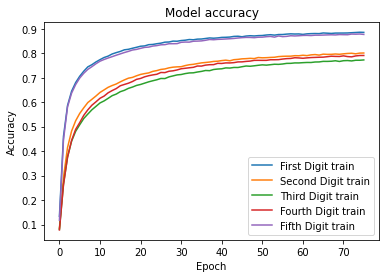

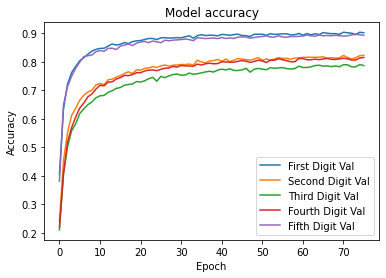

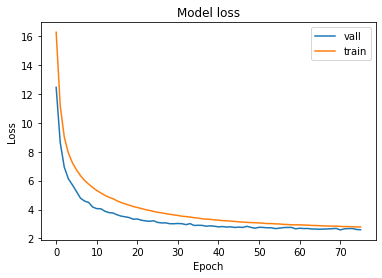

2860/2860 [==============================] - 55s 19ms/step - loss: 1.1480 - digit0_loss: 0.1200 - digit1_loss: 0.2717 - digit2_loss: 0.3407 - digit3_loss: 0.2886 - digit4_loss: 0.1271 - digit0_accuracy: 0.9637 - digit1_accuracy: 0.9253 - digit2_accuracy: 0.9070 - digit3_accuracy: 0.9172 - digit4_accuracy: 0.9634
Train loss:     0.433800
Train accuracy: 71.47
357/357 [==============================] - 7s 20ms/step - loss: 2.5680 - digit0_loss: 0.3133 - digit1_loss: 0.6022 - digit2_loss: 0.7196 - digit3_loss: 0.6224 - digit4_loss: 0.3105 - digit0_accuracy: 0.9054 - digit1_accuracy: 0.8247 - digit2_accuracy: 0.7918 - digit3_accuracy: 0.8174 - digit4_accuracy: 0.9015
Test loss:     0.965099
Test accuracy: 43.57


In [39]:
for i in range(1,6):
    print("")
    print("---Start new train trial---")
    print("Patience: ", i)
    Trained_model_base_kag,name_base_kag, hist_base_kag = TrainModel(ModelCifar10((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle, x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)),i )
    


---Start new train trial---
Patience:  1
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "VGG16_simplfied"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 25, 67, 32)   320         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 25, 67, 32)   9248        conv2d_86[0][0]                  
__________________________________________________________________________________________________
max_p

2022-01-17 02:35:33.107196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 17.6822 - digit0_loss: 3.5371 - digit1_loss: 3.5358 - digit2_loss: 3.5360 - digit3_loss: 3.5368 - digit4_loss: 3.5366 - digit0_accuracy: 0.0336 - digit1_accuracy: 0.0337 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0315 - digit4_accuracy: 0.0326

2022-01-17 02:36:21.561958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 51s 70ms/step - loss: 17.6822 - digit0_loss: 3.5371 - digit1_loss: 3.5358 - digit2_loss: 3.5360 - digit3_loss: 3.5368 - digit4_loss: 3.5366 - digit0_accuracy: 0.0336 - digit1_accuracy: 0.0337 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0315 - digit4_accuracy: 0.0326 - val_loss: 17.6049 - val_digit0_loss: 3.5227 - val_digit1_loss: 3.5181 - val_digit2_loss: 3.5212 - val_digit3_loss: 3.5205 - val_digit4_loss: 3.5223 - val_digit0_accuracy: 0.0341 - val_digit1_accuracy: 0.0339 - val_digit2_accuracy: 0.0321 - val_digit3_accuracy: 0.0345 - val_digit4_accuracy: 0.0328
Epoch 2/150
715/715 [==============================] - 49s 69ms/step - loss: 17.6078 - digit0_loss: 3.5223 - digit1_loss: 3.5210 - digit2_loss: 3.5217 - digit3_loss: 3.5215 - digit4_loss: 3.5213 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0332 - digit2_accuracy: 0.0343 - digit3_accuracy: 0.0336 - digit4_accuracy: 0.0326 - val_loss: 17.5988 - val_digit0_loss: 3.5198 - val_digit1_los

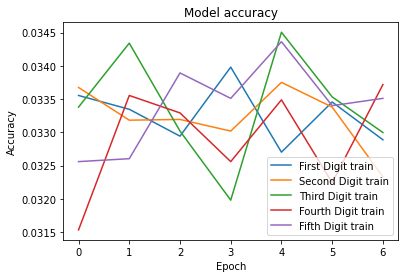

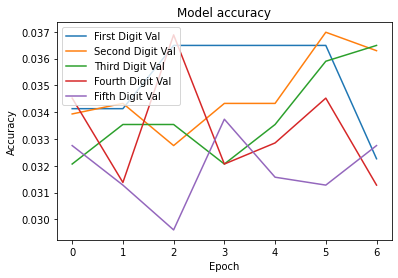

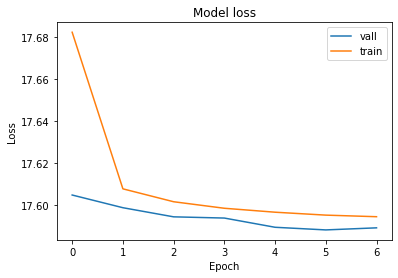

2860/2860 [==============================] - 70s 24ms/step - loss: 17.5900 - digit0_loss: 3.5189 - digit1_loss: 3.5171 - digit2_loss: 3.5180 - digit3_loss: 3.5184 - digit4_loss: 3.5175 - digit0_accuracy: 0.0340 - digit1_accuracy: 0.0350 - digit2_accuracy: 0.0336 - digit3_accuracy: 0.0329 - digit4_accuracy: 0.0330
Train loss:     6.332495
Train accuracy: 0.00
357/357 [==============================] - 9s 24ms/step - loss: 17.5849 - digit0_loss: 3.5207 - digit1_loss: 3.5198 - digit2_loss: 3.5149 - digit3_loss: 3.5162 - digit4_loss: 3.5133 - digit0_accuracy: 0.0367 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0340 - digit3_accuracy: 0.0325 - digit4_accuracy: 0.0321
Test loss:     6.331289
Test accuracy: 0.00

---Start new train trial---
Patience:  2
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "VGG16_simplfied"
________________________________________________________________________________

2022-01-17 02:42:37.470605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 17.6996 - digit0_loss: 3.5417 - digit1_loss: 3.5400 - digit2_loss: 3.5395 - digit3_loss: 3.5395 - digit4_loss: 3.5389 - digit0_accuracy: 0.0328 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0341 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0336

2022-01-17 02:43:25.118118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 50s 69ms/step - loss: 17.6996 - digit0_loss: 3.5417 - digit1_loss: 3.5400 - digit2_loss: 3.5395 - digit3_loss: 3.5395 - digit4_loss: 3.5389 - digit0_accuracy: 0.0328 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0341 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0336 - val_loss: 17.6087 - val_digit0_loss: 3.5221 - val_digit1_loss: 3.5194 - val_digit2_loss: 3.5201 - val_digit3_loss: 3.5186 - val_digit4_loss: 3.5286 - val_digit0_accuracy: 0.0332 - val_digit1_accuracy: 0.0339 - val_digit2_accuracy: 0.0338 - val_digit3_accuracy: 0.0345 - val_digit4_accuracy: 0.0296
Epoch 2/150
715/715 [==============================] - 49s 68ms/step - loss: 17.6084 - digit0_loss: 3.5224 - digit1_loss: 3.5211 - digit2_loss: 3.5220 - digit3_loss: 3.5219 - digit4_loss: 3.5211 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0342 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0331 - digit4_accuracy: 0.0329 - val_loss: 17.5979 - val_digit0_loss: 3.5222 - val_digit1_los

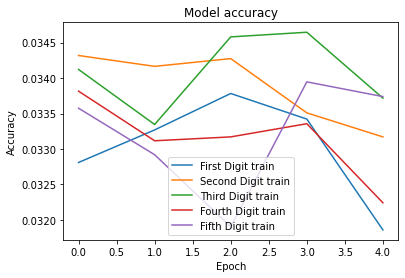

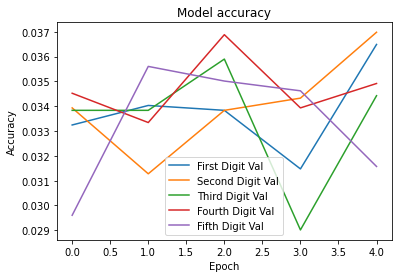

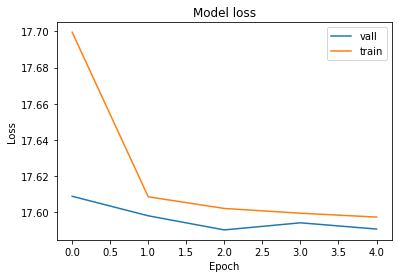

2860/2860 [==============================] - 71s 25ms/step - loss: 17.5912 - digit0_loss: 3.5193 - digit1_loss: 3.5177 - digit2_loss: 3.5185 - digit3_loss: 3.5181 - digit4_loss: 3.5176 - digit0_accuracy: 0.0349 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0340 - digit3_accuracy: 0.0343 - digit4_accuracy: 0.0332
Train loss:     6.332941
Train accuracy: 0.00
357/357 [==============================] - 9s 25ms/step - loss: 17.5862 - digit0_loss: 3.5206 - digit1_loss: 3.5202 - digit2_loss: 3.5159 - digit3_loss: 3.5160 - digit4_loss: 3.5135 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0368 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0305 - digit4_accuracy: 0.0347
Test loss:     6.331785
Test accuracy: 0.00

---Start new train trial---
Patience:  3
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "VGG16_simplfied"
________________________________________________________________________________

2022-01-17 02:48:03.556732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 17.6979 - digit0_loss: 3.5399 - digit1_loss: 3.5392 - digit2_loss: 3.5401 - digit3_loss: 3.5396 - digit4_loss: 3.5392 - digit0_accuracy: 0.0340 - digit1_accuracy: 0.0328 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0340 - digit4_accuracy: 0.0336

2022-01-17 02:48:52.855096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 52s 72ms/step - loss: 17.6979 - digit0_loss: 3.5399 - digit1_loss: 3.5392 - digit2_loss: 3.5401 - digit3_loss: 3.5396 - digit4_loss: 3.5392 - digit0_accuracy: 0.0340 - digit1_accuracy: 0.0328 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0340 - digit4_accuracy: 0.0336 - val_loss: 17.6105 - val_digit0_loss: 3.5229 - val_digit1_loss: 3.5202 - val_digit2_loss: 3.5229 - val_digit3_loss: 3.5204 - val_digit4_loss: 3.5242 - val_digit0_accuracy: 0.0315 - val_digit1_accuracy: 0.0343 - val_digit2_accuracy: 0.0359 - val_digit3_accuracy: 0.0339 - val_digit4_accuracy: 0.0362
Epoch 2/150
715/715 [==============================] - 51s 71ms/step - loss: 17.6093 - digit0_loss: 3.5228 - digit1_loss: 3.5210 - digit2_loss: 3.5219 - digit3_loss: 3.5219 - digit4_loss: 3.5216 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0336 - digit2_accuracy: 0.0340 - digit3_accuracy: 0.0332 - digit4_accuracy: 0.0325 - val_loss: 17.5969 - val_digit0_loss: 3.5198 - val_digit1_los

715/715 [==============================] - 52s 72ms/step - loss: 17.5920 - digit0_loss: 3.5191 - digit1_loss: 3.5177 - digit2_loss: 3.5187 - digit3_loss: 3.5185 - digit4_loss: 3.5180 - digit0_accuracy: 0.0334 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0327 - digit3_accuracy: 0.0332 - digit4_accuracy: 0.0330 - val_loss: 17.5868 - val_digit0_loss: 3.5185 - val_digit1_loss: 3.5156 - val_digit2_loss: 3.5166 - val_digit3_loss: 3.5155 - val_digit4_loss: 3.5207 - val_digit0_accuracy: 0.0334 - val_digit1_accuracy: 0.0370 - val_digit2_accuracy: 0.0352 - val_digit3_accuracy: 0.0349 - val_digit4_accuracy: 0.0311
Epoch 15/150
715/715 [==============================] - 52s 72ms/step - loss: 17.5912 - digit0_loss: 3.5191 - digit1_loss: 3.5175 - digit2_loss: 3.5184 - digit3_loss: 3.5181 - digit4_loss: 3.5180 - digit0_accuracy: 0.0339 - digit1_accuracy: 0.0334 - digit2_accuracy: 0.0328 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0330 - val_loss: 17.5879 - val_digit0_loss: 3.5186 - val_digit1_lo

715/715 [==============================] - 52s 72ms/step - loss: 17.5891 - digit0_loss: 3.5187 - digit1_loss: 3.5171 - digit2_loss: 3.5180 - digit3_loss: 3.5179 - digit4_loss: 3.5175 - digit0_accuracy: 0.0342 - digit1_accuracy: 0.0332 - digit2_accuracy: 0.0327 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0334 - val_loss: 17.5855 - val_digit0_loss: 3.5184 - val_digit1_loss: 3.5153 - val_digit2_loss: 3.5164 - val_digit3_loss: 3.5152 - val_digit4_loss: 3.5202 - val_digit0_accuracy: 0.0365 - val_digit1_accuracy: 0.0363 - val_digit2_accuracy: 0.0352 - val_digit3_accuracy: 0.0339 - val_digit4_accuracy: 0.0356
Epoch 28/150
715/715 [==============================] - 52s 72ms/step - loss: 17.5891 - digit0_loss: 3.5186 - digit1_loss: 3.5171 - digit2_loss: 3.5180 - digit3_loss: 3.5179 - digit4_loss: 3.5175 - digit0_accuracy: 0.0344 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0330 - digit3_accuracy: 0.0345 - digit4_accuracy: 0.0334 - val_loss: 17.5864 - val_digit0_loss: 3.5185 - val_digit1_lo

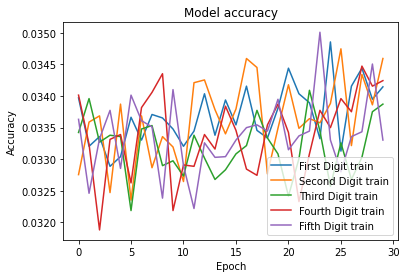

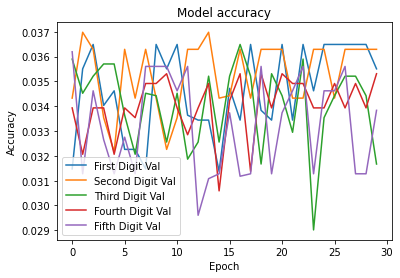

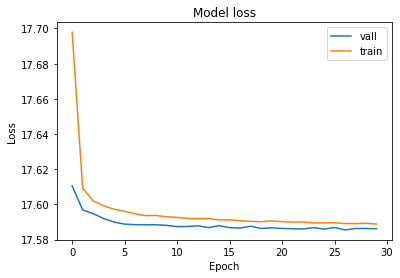

2860/2860 [==============================] - 80s 28ms/step - loss: 17.5869 - digit0_loss: 3.5183 - digit1_loss: 3.5166 - digit2_loss: 3.5175 - digit3_loss: 3.5175 - digit4_loss: 3.5170 - digit0_accuracy: 0.0334 - digit1_accuracy: 0.0350 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0333
Train loss:     6.331363
Train accuracy: 0.00
357/357 [==============================] - 10s 28ms/step - loss: 17.5819 - digit0_loss: 3.5202 - digit1_loss: 3.5186 - digit2_loss: 3.5147 - digit3_loss: 3.5152 - digit4_loss: 3.5131 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0323 - digit3_accuracy: 0.0355 - digit4_accuracy: 0.0308
Test loss:     6.330151
Test accuracy: 0.00

---Start new train trial---
Patience:  4
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "VGG16_simplfied"
_______________________________________________________________________________

2022-01-17 03:15:24.612279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 17.6991 - digit0_loss: 3.5413 - digit1_loss: 3.5396 - digit2_loss: 3.5401 - digit3_loss: 3.5400 - digit4_loss: 3.5381 - digit0_accuracy: 0.0339 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0324 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0336

2022-01-17 03:16:15.326929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 54s 74ms/step - loss: 17.6991 - digit0_loss: 3.5413 - digit1_loss: 3.5396 - digit2_loss: 3.5401 - digit3_loss: 3.5400 - digit4_loss: 3.5381 - digit0_accuracy: 0.0339 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0324 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0336 - val_loss: 17.6083 - val_digit0_loss: 3.5215 - val_digit1_loss: 3.5191 - val_digit2_loss: 3.5215 - val_digit3_loss: 3.5202 - val_digit4_loss: 3.5260 - val_digit0_accuracy: 0.0336 - val_digit1_accuracy: 0.0333 - val_digit2_accuracy: 0.0319 - val_digit3_accuracy: 0.0337 - val_digit4_accuracy: 0.0344
Epoch 2/150
715/715 [==============================] - 52s 73ms/step - loss: 17.6085 - digit0_loss: 3.5223 - digit1_loss: 3.5208 - digit2_loss: 3.5218 - digit3_loss: 3.5221 - digit4_loss: 3.5216 - digit0_accuracy: 0.0335 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0330 - digit3_accuracy: 0.0334 - digit4_accuracy: 0.0326 - val_loss: 17.5969 - val_digit0_loss: 3.5206 - val_digit1_los

715/715 [==============================] - 52s 73ms/step - loss: 17.5912 - digit0_loss: 3.5190 - digit1_loss: 3.5175 - digit2_loss: 3.5185 - digit3_loss: 3.5185 - digit4_loss: 3.5178 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0336 - digit2_accuracy: 0.0323 - digit3_accuracy: 0.0342 - digit4_accuracy: 0.0333 - val_loss: 17.5868 - val_digit0_loss: 3.5183 - val_digit1_loss: 3.5157 - val_digit2_loss: 3.5165 - val_digit3_loss: 3.5158 - val_digit4_loss: 3.5205 - val_digit0_accuracy: 0.0365 - val_digit1_accuracy: 0.0363 - val_digit2_accuracy: 0.0357 - val_digit3_accuracy: 0.0349 - val_digit4_accuracy: 0.0338
Epoch 15/150
715/715 [==============================] - 52s 73ms/step - loss: 17.5912 - digit0_loss: 3.5190 - digit1_loss: 3.5174 - digit2_loss: 3.5186 - digit3_loss: 3.5184 - digit4_loss: 3.5178 - digit0_accuracy: 0.0337 - digit1_accuracy: 0.0337 - digit2_accuracy: 0.0326 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0335 - val_loss: 17.5866 - val_digit0_loss: 3.5184 - val_digit1_lo

715/715 [==============================] - 52s 73ms/step - loss: 17.5891 - digit0_loss: 3.5187 - digit1_loss: 3.5171 - digit2_loss: 3.5179 - digit3_loss: 3.5180 - digit4_loss: 3.5174 - digit0_accuracy: 0.0336 - digit1_accuracy: 0.0342 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0340 - digit4_accuracy: 0.0338 - val_loss: 17.5862 - val_digit0_loss: 3.5184 - val_digit1_loss: 3.5157 - val_digit2_loss: 3.5167 - val_digit3_loss: 3.5151 - val_digit4_loss: 3.5202 - val_digit0_accuracy: 0.0365 - val_digit1_accuracy: 0.0331 - val_digit2_accuracy: 0.0344 - val_digit3_accuracy: 0.0349 - val_digit4_accuracy: 0.0313
Number of finished epochs:  27
Saved trained model at /Users/xiao/Documents/GitHub/TextCaptchaPR/Captcha/saved_models 


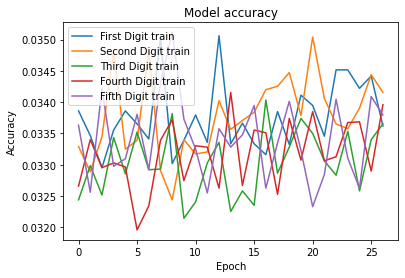

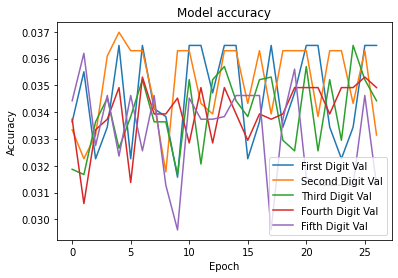

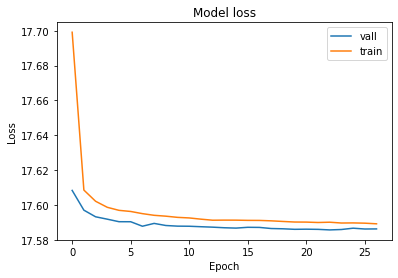

2860/2860 [==============================] - 82s 28ms/step - loss: 17.5871 - digit0_loss: 3.5182 - digit1_loss: 3.5167 - digit2_loss: 3.5176 - digit3_loss: 3.5175 - digit4_loss: 3.5171 - digit0_accuracy: 0.0349 - digit1_accuracy: 0.0335 - digit2_accuracy: 0.0340 - digit3_accuracy: 0.0343 - digit4_accuracy: 0.0345
Train loss:     6.331430
Train accuracy: 0.00
357/357 [==============================] - 10s 29ms/step - loss: 17.5824 - digit0_loss: 3.5202 - digit1_loss: 3.5187 - digit2_loss: 3.5150 - digit3_loss: 3.5155 - digit4_loss: 3.5130 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0305 - digit4_accuracy: 0.0330
Test loss:     6.330362
Test accuracy: 0.00

---Start new train trial---
Patience:  5
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "VGG16_simplfied"
_______________________________________________________________________________

2022-01-17 03:40:27.696394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 17.6949 - digit0_loss: 3.5410 - digit1_loss: 3.5383 - digit2_loss: 3.5372 - digit3_loss: 3.5393 - digit4_loss: 3.5390 - digit0_accuracy: 0.0348 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0330 - digit3_accuracy: 0.0337 - digit4_accuracy: 0.0332

2022-01-17 03:41:18.819669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 54s 75ms/step - loss: 17.6949 - digit0_loss: 3.5410 - digit1_loss: 3.5383 - digit2_loss: 3.5372 - digit3_loss: 3.5393 - digit4_loss: 3.5390 - digit0_accuracy: 0.0348 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0330 - digit3_accuracy: 0.0337 - digit4_accuracy: 0.0332 - val_loss: 17.6052 - val_digit0_loss: 3.5212 - val_digit1_loss: 3.5191 - val_digit2_loss: 3.5222 - val_digit3_loss: 3.5186 - val_digit4_loss: 3.5241 - val_digit0_accuracy: 0.0316 - val_digit1_accuracy: 0.0328 - val_digit2_accuracy: 0.0336 - val_digit3_accuracy: 0.0342 - val_digit4_accuracy: 0.0362
Epoch 2/150
715/715 [==============================] - 53s 74ms/step - loss: 17.6085 - digit0_loss: 3.5224 - digit1_loss: 3.5209 - digit2_loss: 3.5219 - digit3_loss: 3.5219 - digit4_loss: 3.5213 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0332 - digit3_accuracy: 0.0330 - digit4_accuracy: 0.0340 - val_loss: 17.6014 - val_digit0_loss: 3.5207 - val_digit1_los

715/715 [==============================] - 53s 74ms/step - loss: 17.5918 - digit0_loss: 3.5193 - digit1_loss: 3.5175 - digit2_loss: 3.5187 - digit3_loss: 3.5182 - digit4_loss: 3.5180 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0331 - digit3_accuracy: 0.0334 - digit4_accuracy: 0.0336 - val_loss: 17.5871 - val_digit0_loss: 3.5184 - val_digit1_loss: 3.5157 - val_digit2_loss: 3.5171 - val_digit3_loss: 3.5156 - val_digit4_loss: 3.5203 - val_digit0_accuracy: 0.0326 - val_digit1_accuracy: 0.0338 - val_digit2_accuracy: 0.0335 - val_digit3_accuracy: 0.0306 - val_digit4_accuracy: 0.0346
Epoch 15/150
715/715 [==============================] - 53s 74ms/step - loss: 17.5911 - digit0_loss: 3.5190 - digit1_loss: 3.5175 - digit2_loss: 3.5184 - digit3_loss: 3.5183 - digit4_loss: 3.5179 - digit0_accuracy: 0.0344 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0338 - digit3_accuracy: 0.0337 - digit4_accuracy: 0.0334 - val_loss: 17.5864 - val_digit0_loss: 3.5185 - val_digit1_lo

715/715 [==============================] - 53s 74ms/step - loss: 17.5891 - digit0_loss: 3.5188 - digit1_loss: 3.5170 - digit2_loss: 3.5179 - digit3_loss: 3.5180 - digit4_loss: 3.5174 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0337 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0330 - digit4_accuracy: 0.0335 - val_loss: 17.5856 - val_digit0_loss: 3.5182 - val_digit1_loss: 3.5156 - val_digit2_loss: 3.5165 - val_digit3_loss: 3.5150 - val_digit4_loss: 3.5202 - val_digit0_accuracy: 0.0365 - val_digit1_accuracy: 0.0335 - val_digit2_accuracy: 0.0317 - val_digit3_accuracy: 0.0353 - val_digit4_accuracy: 0.0346
Epoch 28/150
715/715 [==============================] - 53s 73ms/step - loss: 17.5896 - digit0_loss: 3.5187 - digit1_loss: 3.5173 - digit2_loss: 3.5180 - digit3_loss: 3.5179 - digit4_loss: 3.5176 - digit0_accuracy: 0.0338 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0338 - digit3_accuracy: 0.0324 - digit4_accuracy: 0.0326 - val_loss: 17.5859 - val_digit0_loss: 3.5182 - val_digit1_lo

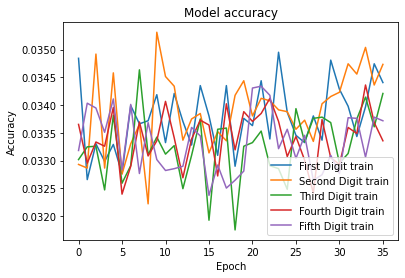

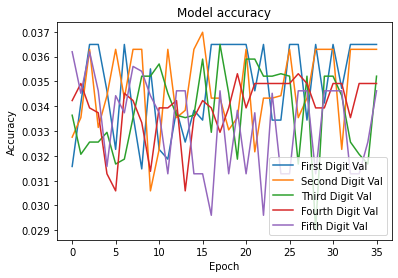

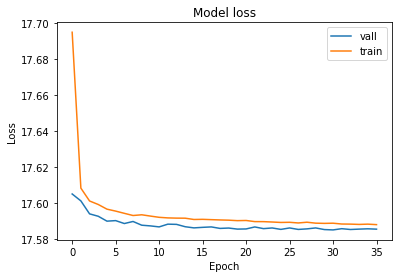

2860/2860 [==============================] - 83s 29ms/step - loss: 17.5865 - digit0_loss: 3.5181 - digit1_loss: 3.5166 - digit2_loss: 3.5175 - digit3_loss: 3.5174 - digit4_loss: 3.5169 - digit0_accuracy: 0.0349 - digit1_accuracy: 0.0350 - digit2_accuracy: 0.0343 - digit3_accuracy: 0.0343 - digit4_accuracy: 0.0344
Train loss:     6.331222
Train accuracy: 0.00
357/357 [==============================] - 10s 29ms/step - loss: 17.5817 - digit0_loss: 3.5203 - digit1_loss: 3.5188 - digit2_loss: 3.5145 - digit3_loss: 3.5152 - digit4_loss: 3.5128 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0343 - digit2_accuracy: 0.0359 - digit3_accuracy: 0.0305 - digit4_accuracy: 0.0314
Test loss:     6.330099
Test accuracy: 0.00


In [48]:
for i in range(1,6):
    print("")
    print("---Start new train trial---")
    print("Patience: ", i)
    Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle, x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)),i )

#     Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle,x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)),i )



---Start new train trial---
Patience:  1
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 25, 67, 32)   320         input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 25, 67, 32)   128         conv2d_158[0][0]                 
__________________________________________________________________________________________________
conv2d_159 (C

2022-01-17 08:16:05.016113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 14.0628 - digit0_loss: 2.5051 - digit1_loss: 2.9517 - digit2_loss: 3.0384 - digit3_loss: 2.9992 - digit4_loss: 2.5684 - digit0_accuracy: 0.3380 - digit1_accuracy: 0.2141 - digit2_accuracy: 0.1903 - digit3_accuracy: 0.1984 - digit4_accuracy: 0.3283

2022-01-17 08:16:46.312240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 44s 61ms/step - loss: 14.0628 - digit0_loss: 2.5051 - digit1_loss: 2.9517 - digit2_loss: 3.0384 - digit3_loss: 2.9992 - digit4_loss: 2.5684 - digit0_accuracy: 0.3380 - digit1_accuracy: 0.2141 - digit2_accuracy: 0.1903 - digit3_accuracy: 0.1984 - digit4_accuracy: 0.3283 - val_loss: 9.9630 - val_digit0_loss: 1.5567 - val_digit1_loss: 2.1948 - val_digit2_loss: 2.3449 - val_digit3_loss: 2.2854 - val_digit4_loss: 1.5814 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4325 - val_digit2_accuracy: 0.3984 - val_digit3_accuracy: 0.3990 - val_digit4_accuracy: 0.6006
Epoch 2/150
715/715 [==============================] - 42s 59ms/step - loss: 6.7817 - digit0_loss: 0.9190 - digit1_loss: 1.5275 - digit2_loss: 1.7428 - digit3_loss: 1.6190 - digit4_loss: 0.9734 - digit0_accuracy: 0.8074 - digit1_accuracy: 0.6302 - digit2_accuracy: 0.5644 - digit3_accuracy: 0.6014 - digit4_accuracy: 0.7906 - val_loss: 5.0337 - val_digit0_loss: 0.6941 - val_digit1_loss: 

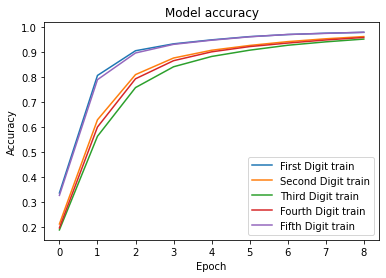

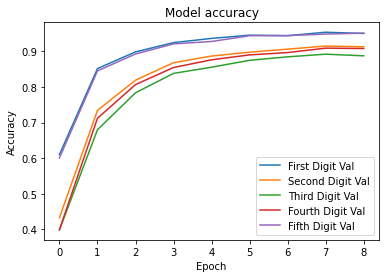

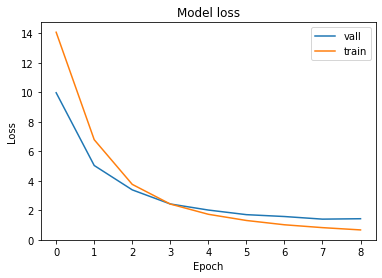

2860/2860 [==============================] - 83s 29ms/step - loss: 0.6312 - digit0_loss: 0.0870 - digit1_loss: 0.1409 - digit2_loss: 0.1717 - digit3_loss: 0.1474 - digit4_loss: 0.0843 - digit0_accuracy: 0.9805 - digit1_accuracy: 0.9650 - digit2_accuracy: 0.9555 - digit3_accuracy: 0.9625 - digit4_accuracy: 0.9813
Train loss:     0.235644
Train accuracy: 85.39
357/357 [==============================] - 10s 29ms/step - loss: 1.4428 - digit0_loss: 0.1818 - digit1_loss: 0.3402 - digit2_loss: 0.4075 - digit3_loss: 0.3313 - digit4_loss: 0.1819 - digit0_accuracy: 0.9516 - digit1_accuracy: 0.9090 - digit2_accuracy: 0.8887 - digit3_accuracy: 0.9105 - digit4_accuracy: 0.9523
Test loss:     0.540724
Test accuracy: 66.65

---Start new train trial---
Patience:  2
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "model_10"
______________________________________________________________________________________

2022-01-17 08:24:01.038025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 14.2976 - digit0_loss: 2.5440 - digit1_loss: 2.9877 - digit2_loss: 3.0661 - digit3_loss: 3.0528 - digit4_loss: 2.6470 - digit0_accuracy: 0.3261 - digit1_accuracy: 0.1996 - digit2_accuracy: 0.1776 - digit3_accuracy: 0.1858 - digit4_accuracy: 0.3057

2022-01-17 08:24:42.337754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 44s 61ms/step - loss: 14.2976 - digit0_loss: 2.5440 - digit1_loss: 2.9877 - digit2_loss: 3.0661 - digit3_loss: 3.0528 - digit4_loss: 2.6470 - digit0_accuracy: 0.3261 - digit1_accuracy: 0.1996 - digit2_accuracy: 0.1776 - digit3_accuracy: 0.1858 - digit4_accuracy: 0.3057 - val_loss: 10.0705 - val_digit0_loss: 1.4917 - val_digit1_loss: 2.2171 - val_digit2_loss: 2.3965 - val_digit3_loss: 2.3332 - val_digit4_loss: 1.6321 - val_digit0_accuracy: 0.6100 - val_digit1_accuracy: 0.4169 - val_digit2_accuracy: 0.3743 - val_digit3_accuracy: 0.3969 - val_digit4_accuracy: 0.5827
Epoch 2/150
715/715 [==============================] - 42s 59ms/step - loss: 6.8896 - digit0_loss: 0.9292 - digit1_loss: 1.5581 - digit2_loss: 1.7844 - digit3_loss: 1.6608 - digit4_loss: 0.9572 - digit0_accuracy: 0.8015 - digit1_accuracy: 0.6150 - digit2_accuracy: 0.5499 - digit3_accuracy: 0.5877 - digit4_accuracy: 0.7945 - val_loss: 5.1821 - val_digit0_loss: 0.7287 - val_digit1_loss:

715/715 [==============================] - 42s 59ms/step - loss: 0.3144 - digit0_loss: 0.0427 - digit1_loss: 0.0684 - digit2_loss: 0.0862 - digit3_loss: 0.0736 - digit4_loss: 0.0434 - digit0_accuracy: 0.9899 - digit1_accuracy: 0.9831 - digit2_accuracy: 0.9776 - digit3_accuracy: 0.9813 - digit4_accuracy: 0.9895 - val_loss: 1.3262 - val_digit0_loss: 0.1704 - val_digit1_loss: 0.3024 - val_digit2_loss: 0.3718 - val_digit3_loss: 0.3092 - val_digit4_loss: 0.1724 - val_digit0_accuracy: 0.9551 - val_digit1_accuracy: 0.9228 - val_digit2_accuracy: 0.9022 - val_digit3_accuracy: 0.9155 - val_digit4_accuracy: 0.9553
Number of finished epochs:  14
Saved trained model at /Users/xiao/Documents/GitHub/TextCaptchaPR/Captcha/saved_models 


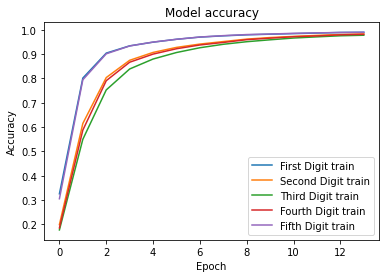

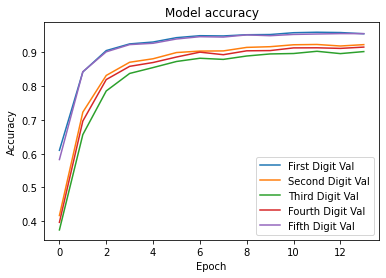

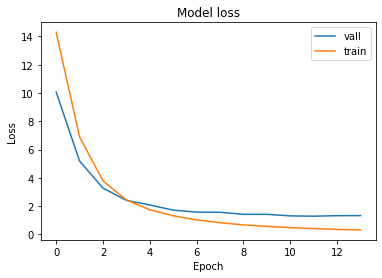

2860/2860 [==============================] - 82s 28ms/step - loss: 0.2943 - digit0_loss: 0.0428 - digit1_loss: 0.0621 - digit2_loss: 0.0764 - digit3_loss: 0.0666 - digit4_loss: 0.0464 - digit0_accuracy: 0.9900 - digit1_accuracy: 0.9842 - digit2_accuracy: 0.9806 - digit3_accuracy: 0.9841 - digit4_accuracy: 0.9894
Train loss:     0.108450
Train accuracy: 93.03
357/357 [==============================] - 10s 29ms/step - loss: 1.3136 - digit0_loss: 0.1591 - digit1_loss: 0.2992 - digit2_loss: 0.3774 - digit3_loss: 0.2985 - digit4_loss: 0.1794 - digit0_accuracy: 0.9580 - digit1_accuracy: 0.9222 - digit2_accuracy: 0.9014 - digit3_accuracy: 0.9200 - digit4_accuracy: 0.9544
Test loss:     0.489548
Test accuracy: 69.92

---Start new train trial---
Patience:  3
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "model_11"
______________________________________________________________________________________

2022-01-17 08:35:27.279106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 13.9215 - digit0_loss: 2.4451 - digit1_loss: 2.9384 - digit2_loss: 3.0325 - digit3_loss: 3.0091 - digit4_loss: 2.4963 - digit0_accuracy: 0.3447 - digit1_accuracy: 0.2157 - digit2_accuracy: 0.1921 - digit3_accuracy: 0.1993 - digit4_accuracy: 0.3453

2022-01-17 08:36:08.180670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 44s 60ms/step - loss: 13.9215 - digit0_loss: 2.4451 - digit1_loss: 2.9384 - digit2_loss: 3.0325 - digit3_loss: 3.0091 - digit4_loss: 2.4963 - digit0_accuracy: 0.3447 - digit1_accuracy: 0.2157 - digit2_accuracy: 0.1921 - digit3_accuracy: 0.1993 - digit4_accuracy: 0.3453 - val_loss: 9.9756 - val_digit0_loss: 1.5215 - val_digit1_loss: 2.2239 - val_digit2_loss: 2.3635 - val_digit3_loss: 2.3097 - val_digit4_loss: 1.5570 - val_digit0_accuracy: 0.6009 - val_digit1_accuracy: 0.4162 - val_digit2_accuracy: 0.3904 - val_digit3_accuracy: 0.3942 - val_digit4_accuracy: 0.6098
Epoch 2/150
715/715 [==============================] - 42s 59ms/step - loss: 6.9082 - digit0_loss: 0.9377 - digit1_loss: 1.5801 - digit2_loss: 1.7814 - digit3_loss: 1.6612 - digit4_loss: 0.9477 - digit0_accuracy: 0.7963 - digit1_accuracy: 0.6082 - digit2_accuracy: 0.5485 - digit3_accuracy: 0.5844 - digit4_accuracy: 0.7913 - val_loss: 5.2774 - val_digit0_loss: 0.7780 - val_digit1_loss: 

715/715 [==============================] - 42s 59ms/step - loss: 0.3254 - digit0_loss: 0.0429 - digit1_loss: 0.0732 - digit2_loss: 0.0878 - digit3_loss: 0.0764 - digit4_loss: 0.0450 - digit0_accuracy: 0.9893 - digit1_accuracy: 0.9813 - digit2_accuracy: 0.9772 - digit3_accuracy: 0.9809 - digit4_accuracy: 0.9889 - val_loss: 1.3295 - val_digit0_loss: 0.1615 - val_digit1_loss: 0.3002 - val_digit2_loss: 0.3939 - val_digit3_loss: 0.3121 - val_digit4_loss: 0.1618 - val_digit0_accuracy: 0.9569 - val_digit1_accuracy: 0.9173 - val_digit2_accuracy: 0.8946 - val_digit3_accuracy: 0.9161 - val_digit4_accuracy: 0.9565
Epoch 15/150
715/715 [==============================] - 42s 59ms/step - loss: 0.2785 - digit0_loss: 0.0388 - digit1_loss: 0.0627 - digit2_loss: 0.0742 - digit3_loss: 0.0647 - digit4_loss: 0.0380 - digit0_accuracy: 0.9904 - digit1_accuracy: 0.9848 - digit2_accuracy: 0.9811 - digit3_accuracy: 0.9842 - digit4_accuracy: 0.9914 - val_loss: 1.3846 - val_digit0_loss: 0.1725 - val_digit1_loss: 

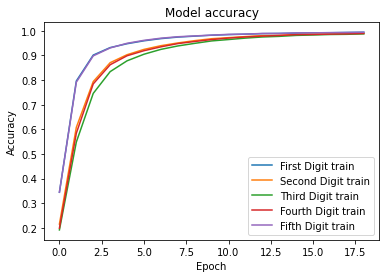

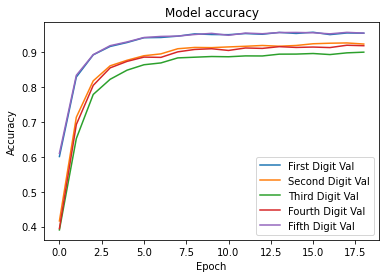

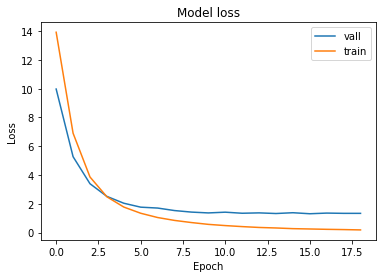

2860/2860 [==============================] - 83s 29ms/step - loss: 0.1882 - digit0_loss: 0.0273 - digit1_loss: 0.0403 - digit2_loss: 0.0491 - digit3_loss: 0.0438 - digit4_loss: 0.0278 - digit0_accuracy: 0.9937 - digit1_accuracy: 0.9903 - digit2_accuracy: 0.9887 - digit3_accuracy: 0.9899 - digit4_accuracy: 0.9933
Train loss:     0.069735
Train accuracy: 95.65
357/357 [==============================] - 11s 29ms/step - loss: 1.3094 - digit0_loss: 0.1520 - digit1_loss: 0.2897 - digit2_loss: 0.3952 - digit3_loss: 0.3074 - digit4_loss: 0.1651 - digit0_accuracy: 0.9593 - digit1_accuracy: 0.9244 - digit2_accuracy: 0.8992 - digit3_accuracy: 0.9207 - digit4_accuracy: 0.9596
Test loss:     0.490751
Test accuracy: 70.45

---Start new train trial---
Patience:  4
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "model_12"
______________________________________________________________________________________

2022-01-17 08:50:25.173334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 14.1320 - digit0_loss: 2.4868 - digit1_loss: 2.9955 - digit2_loss: 3.0813 - digit3_loss: 3.0457 - digit4_loss: 2.5226 - digit0_accuracy: 0.3368 - digit1_accuracy: 0.1981 - digit2_accuracy: 0.1725 - digit3_accuracy: 0.1826 - digit4_accuracy: 0.3286

2022-01-17 08:51:07.002111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 45s 62ms/step - loss: 14.1320 - digit0_loss: 2.4868 - digit1_loss: 2.9955 - digit2_loss: 3.0813 - digit3_loss: 3.0457 - digit4_loss: 2.5226 - digit0_accuracy: 0.3368 - digit1_accuracy: 0.1981 - digit2_accuracy: 0.1725 - digit3_accuracy: 0.1826 - digit4_accuracy: 0.3286 - val_loss: 10.2669 - val_digit0_loss: 1.5748 - val_digit1_loss: 2.2805 - val_digit2_loss: 2.4527 - val_digit3_loss: 2.3724 - val_digit4_loss: 1.5865 - val_digit0_accuracy: 0.5944 - val_digit1_accuracy: 0.3924 - val_digit2_accuracy: 0.3470 - val_digit3_accuracy: 0.3697 - val_digit4_accuracy: 0.5751
Epoch 2/150
715/715 [==============================] - 43s 60ms/step - loss: 6.9978 - digit0_loss: 0.9639 - digit1_loss: 1.5946 - digit2_loss: 1.8014 - digit3_loss: 1.6781 - digit4_loss: 0.9597 - digit0_accuracy: 0.7894 - digit1_accuracy: 0.6032 - digit2_accuracy: 0.5435 - digit3_accuracy: 0.5774 - digit4_accuracy: 0.7902 - val_loss: 5.2884 - val_digit0_loss: 0.7335 - val_digit1_loss:

715/715 [==============================] - 43s 60ms/step - loss: 0.3243 - digit0_loss: 0.0431 - digit1_loss: 0.0724 - digit2_loss: 0.0878 - digit3_loss: 0.0756 - digit4_loss: 0.0453 - digit0_accuracy: 0.9897 - digit1_accuracy: 0.9820 - digit2_accuracy: 0.9774 - digit3_accuracy: 0.9808 - digit4_accuracy: 0.9896 - val_loss: 1.3500 - val_digit0_loss: 0.1741 - val_digit1_loss: 0.2903 - val_digit2_loss: 0.3967 - val_digit3_loss: 0.3128 - val_digit4_loss: 0.1762 - val_digit0_accuracy: 0.9528 - val_digit1_accuracy: 0.9205 - val_digit2_accuracy: 0.8959 - val_digit3_accuracy: 0.9152 - val_digit4_accuracy: 0.9517
Epoch 15/150
715/715 [==============================] - 43s 60ms/step - loss: 0.2839 - digit0_loss: 0.0386 - digit1_loss: 0.0632 - digit2_loss: 0.0761 - digit3_loss: 0.0672 - digit4_loss: 0.0388 - digit0_accuracy: 0.9910 - digit1_accuracy: 0.9843 - digit2_accuracy: 0.9798 - digit3_accuracy: 0.9830 - digit4_accuracy: 0.9910 - val_loss: 1.3421 - val_digit0_loss: 0.1590 - val_digit1_loss: 

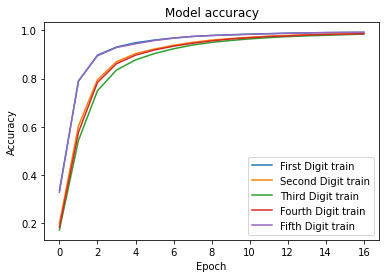

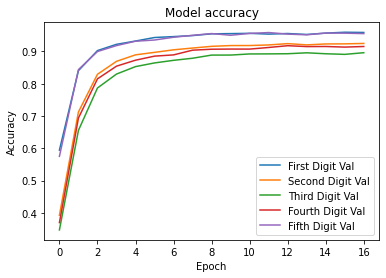

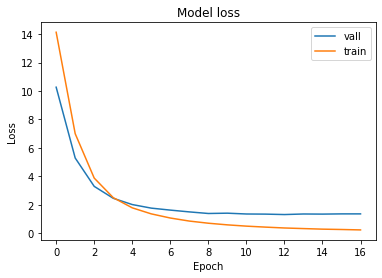

2860/2860 [==============================] - 84s 29ms/step - loss: 0.2318 - digit0_loss: 0.0359 - digit1_loss: 0.0491 - digit2_loss: 0.0587 - digit3_loss: 0.0555 - digit4_loss: 0.0327 - digit0_accuracy: 0.9917 - digit1_accuracy: 0.9887 - digit2_accuracy: 0.9857 - digit3_accuracy: 0.9860 - digit4_accuracy: 0.9924
Train loss:     0.086172
Train accuracy: 94.57
357/357 [==============================] - 11s 30ms/step - loss: 1.3180 - digit0_loss: 0.1604 - digit1_loss: 0.2991 - digit2_loss: 0.3846 - digit3_loss: 0.3114 - digit4_loss: 0.1625 - digit0_accuracy: 0.9580 - digit1_accuracy: 0.9200 - digit2_accuracy: 0.9014 - digit3_accuracy: 0.9181 - digit4_accuracy: 0.9558
Test loss:     0.494701
Test accuracy: 69.71

---Start new train trial---
Patience:  5
Total data set size:  102895
Training size:  91496
Testing size:  11399
Validation size:  10167
Number of epochs:  150
Batch size:  128
Model: "model_13"
______________________________________________________________________________________

2022-01-17 09:04:07.714158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - ETA: 0s - loss: 14.5395 - digit0_loss: 2.6324 - digit1_loss: 3.0531 - digit2_loss: 3.1071 - digit3_loss: 3.0851 - digit4_loss: 2.6617 - digit0_accuracy: 0.2945 - digit1_accuracy: 0.1788 - digit2_accuracy: 0.1660 - digit3_accuracy: 0.1681 - digit4_accuracy: 0.2921

2022-01-17 09:04:49.071104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


715/715 [==============================] - 44s 61ms/step - loss: 14.5395 - digit0_loss: 2.6324 - digit1_loss: 3.0531 - digit2_loss: 3.1071 - digit3_loss: 3.0851 - digit4_loss: 2.6617 - digit0_accuracy: 0.2945 - digit1_accuracy: 0.1788 - digit2_accuracy: 0.1660 - digit3_accuracy: 0.1681 - digit4_accuracy: 0.2921 - val_loss: 10.3217 - val_digit0_loss: 1.6199 - val_digit1_loss: 2.3029 - val_digit2_loss: 2.4366 - val_digit3_loss: 2.3667 - val_digit4_loss: 1.5956 - val_digit0_accuracy: 0.5788 - val_digit1_accuracy: 0.3967 - val_digit2_accuracy: 0.3523 - val_digit3_accuracy: 0.3707 - val_digit4_accuracy: 0.6063
Epoch 2/150
715/715 [==============================] - 42s 59ms/step - loss: 7.1812 - digit0_loss: 0.9961 - digit1_loss: 1.6337 - digit2_loss: 1.8308 - digit3_loss: 1.7112 - digit4_loss: 1.0094 - digit0_accuracy: 0.7832 - digit1_accuracy: 0.5931 - digit2_accuracy: 0.5337 - digit3_accuracy: 0.5740 - digit4_accuracy: 0.7777 - val_loss: 5.3040 - val_digit0_loss: 0.7438 - val_digit1_loss:

715/715 [==============================] - 42s 59ms/step - loss: 0.3167 - digit0_loss: 0.0433 - digit1_loss: 0.0708 - digit2_loss: 0.0844 - digit3_loss: 0.0736 - digit4_loss: 0.0446 - digit0_accuracy: 0.9898 - digit1_accuracy: 0.9819 - digit2_accuracy: 0.9785 - digit3_accuracy: 0.9819 - digit4_accuracy: 0.9893 - val_loss: 1.3326 - val_digit0_loss: 0.1659 - val_digit1_loss: 0.2894 - val_digit2_loss: 0.3782 - val_digit3_loss: 0.3132 - val_digit4_loss: 0.1858 - val_digit0_accuracy: 0.9571 - val_digit1_accuracy: 0.9228 - val_digit2_accuracy: 0.8959 - val_digit3_accuracy: 0.9139 - val_digit4_accuracy: 0.9485
Epoch 15/150
715/715 [==============================] - 42s 59ms/step - loss: 0.2804 - digit0_loss: 0.0375 - digit1_loss: 0.0630 - digit2_loss: 0.0745 - digit3_loss: 0.0650 - digit4_loss: 0.0403 - digit0_accuracy: 0.9914 - digit1_accuracy: 0.9834 - digit2_accuracy: 0.9810 - digit3_accuracy: 0.9836 - digit4_accuracy: 0.9905 - val_loss: 1.3366 - val_digit0_loss: 0.1706 - val_digit1_loss: 

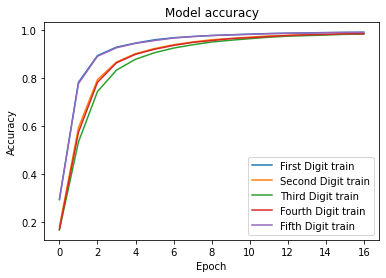

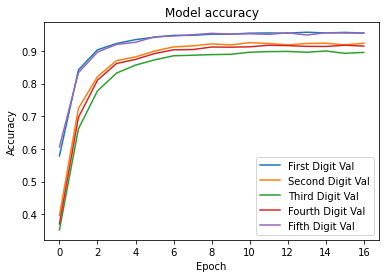

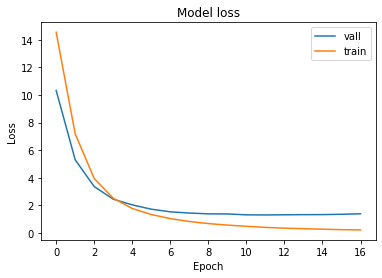

2860/2860 [==============================] - 83s 29ms/step - loss: 0.2785 - digit0_loss: 0.0356 - digit1_loss: 0.0607 - digit2_loss: 0.0766 - digit3_loss: 0.0671 - digit4_loss: 0.0385 - digit0_accuracy: 0.9918 - digit1_accuracy: 0.9843 - digit2_accuracy: 0.9791 - digit3_accuracy: 0.9821 - digit4_accuracy: 0.9909
Train loss:     0.103706
Train accuracy: 93.03
357/357 [==============================] - 10s 29ms/step - loss: 1.3966 - digit0_loss: 0.1659 - digit1_loss: 0.3184 - digit2_loss: 0.4138 - digit3_loss: 0.3274 - digit4_loss: 0.1712 - digit0_accuracy: 0.9550 - digit1_accuracy: 0.9184 - digit2_accuracy: 0.8978 - digit3_accuracy: 0.9203 - digit4_accuracy: 0.9541
Test loss:     0.524403
Test accuracy: 69.14


In [55]:
for i in range(1,6):
    print("")
    print("---Start new train trial---")
    print("Patience: ", i)
    Trained_model_wang_kag,name_wang_kag, hist_wang_kag = TrainModel(ModelWangComplex((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle, x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)),i )

#     Trained_model_wang_kag,name_wang_kag, hist_wang_kag = TrainModel(ModelWangComplex((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle,x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)),i )


In [ ]:
TrainModel(ModelWangComplex((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle, x_valKaggle, s_valKaggle, ('Kag_test_' + str(i)),i )


In [ ]:
Trained_model_base_kag,name_base_kag, hist_base_kag = TrainModel(ModelCifar10((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

In [ ]:
Trained_model_lenet_kag,name_lenet_kag, hist_lenet_kag = TrainModel(ModelLeNet((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

In [ ]:
Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

In [ ]:
Trained_model_alex_kag,name_alex_kag, hist_alex_kag = TrainModel(ModelAlexnet((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle)

In [ ]:
Trained_model = TrainModel(ModelAlexnet((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle)

In [ ]:
Trained_model_vg19_kag,name_vg19_kag, hist_vg19_kag = TrainModel(ModelVGG19((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle)


In [ ]:
Trained_model_vg16c_kag,name_vg16c_kag, hist_vg16c_kag = TrainModel(ModelVGG16complex((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

In [ ]:
# Tests on the generated captcha dataset

In [ ]:
Trained_model_base_gen,name_base_gen, hist_base_gen = TrainModel(ModelCifar10((25, 67, 1)), x_trainGen, s_trainGen, x_testGen, s_testGen, 'Gen')

In [ ]:
Trained_model_lenet_gen,name_lenet_gen, hist_lenet_gen = TrainModel(ModelLeNet((25, 67, 1)), x_trainGen, s_trainGen, x_testGen, s_testGen, 'Gen')

In [ ]:
Trained_model_vg16_gen,name_vg16_gen, hist_vg16_gen = TrainModel(ModelVGG16((25, 67, 1)), x_trainGen, s_trainGen, x_testGen, s_testGen, 'Gen')

In [ ]:
# Expreriment different optimization functions: adam, adagrad, SGD, adedelta, adamax

In [ ]:
#setup: 1. all optimization functions uses the default learning rate
#       2. test on the kaggle dataset 
#       3. no early stopping, we set the epoch size to 40 (based on the baseline test)
#       4. batch size: 256
#       5. using the best baseline model on the kaggle dataset: VGG16 simpelfied
#       6. training set does not change during the experiment

In [ ]:
def ExperimentOptimizers(x_train, s_train):
    optimizers = ["Adadelta","adam", "adagrad", "adamax", "SGD"]

    results = []
#     x_train_opt, x_val_opt, y_train_opt, y_val_opt = train_test_split(x_train, y_train, 
#                                                                            test_size=0.01, random_state=42)

#     s_val_opt = []
#     s_train_opt = []
    epoch = 40
#     for i in range(NUM_OF_LETTERS):
#         s_train_opt.append(y_train_opt[:, i, :])
#         s_val_opt.append(y_val_opt[:, i, :])
    
    print("Training size: ", len(x_train))
    print("Number of epochs: ", epoch)        
    print("Batch size: ", BATCH_SIZE)
    
#     print(s_train_opt.shape)
#     print(s_test_opt.shape)
#     print(s_val_opt.shape)


    for opt in optimizers:
        model_opt, model_name_opt  = ModelVGG16((25, 67, 1))
        model_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        print(model_name_opt + " with the optimizer: " + opt)

        history = model_opt.fit(x_train, s_train,
                batch_size=BATCH_SIZE,
                epochs=epoch,
                verbose=1,
                validation_split= 0.1)
        
        
        results.append((model_opt, history, opt))
        

    return results
        



In [ ]:
experiment_results = ExperimentOptimizers(x_trainKaggle,s_trainKaggle)
    
    

In [ ]:
# (m, h ,n) = experiment_results[0]
# print(h.history)



In [ ]:
# print(test)

# (m, h, n) = experiment_results[1]
# # print(len(results_accuracy))
# test = np.array([h.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)])
# # print(([h.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)][4]))
# print(h.history)
# # print(test)
# for col in test.T:
#     acc = (np.prod(col))
#     print('For each epoch: %.2f' % (acc * 100.))


results_acc = []


for (m,h,n) in experiment_results:
    acc_hist_epoch = []
    acc_val_hist_epoch = []
    loss_hist_epoch = []
    loss_val_hist_epoch = []

    acc_hist = np.array([h.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)])
    acc_val_hist = np.array([h.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)])
    loss_hist = np.array(h.history['loss'])
    loss_val_hist = np.array(h.history['val_loss'])
    
    counter = 1
    for col in loss_hist.T:
#         print("epoch " + str(counter) +  '; the accuracy: %.2f' % (acc * 100.))
        loss_hist_epoch.append(col)
        counter+=1
        
        
    counter = 1
    for col in loss_val_hist.T:
#         print("epoch " + str(counter) +  '; the accuracy: %.2f' % (acc * 100.))
        loss_val_hist_epoch.append(col)
        counter+=1
    
    
#     print("Optimizer " + n)
    counter = 1
    for col in acc_hist.T:
        acc = (np.prod(col))
#         print("epoch " + str(counter) +  '; the accuracy: %.2f' % (acc * 100.))
        acc_hist_epoch.append(acc)
        counter+=1
    
    
    counter = 1
    for col in acc_val_hist.T:
        acc = (np.prod(col))
#         print("epoch " + str(counter) +  '; the validation accuracy: %.2f' % (acc * 100.))
        acc_val_hist_epoch.append(acc)
        counter+=1


    

    results_acc.append((acc_hist_epoch, acc_val_hist_epoch, loss_hist_epoch, loss_val_hist_epoch, n))
    
# print(results_acc)

In [ ]:
for (hist_acc, _, _,_,n) in results_acc:
    plt.plot(hist_acc, label=n)


    
plt.title('Optimizer accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

for (_, hist_acc_val,_,_, n) in results_acc:
    plt.plot(hist_acc_val, label=n)
    
plt.title('Optimizer validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


for (hist_acc, hist_acc_val,_,_, n) in results_acc:
    if(n == 'adam' or n == 'adamax'):
        plt.plot(hist_acc, label=n)
        plt.plot(hist_acc_val, label=n+"_val")


    
plt.title('Optimizer accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



for (_, _, hist_loss ,_, n) in results_acc:
        plt.plot(hist_loss, label=n)


    
plt.title('Optimizer loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



for (_, _, _ ,hist__val_loss, n) in results_acc:
        plt.plot(hist__val_loss, label=n)


    
plt.title('Optimizer validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()




In [ ]:
# Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

In [ ]:
# modelCifar=load_model("saved_models/keras_Cifar10_trained_model.h5")
# # EvaluateScore(modelCifar)

In [ ]:
# modelLeNet=load_model("saved_models/keras_LeNet_trained_model.h5")
# EvaluateScore(modelLeNet)